<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Neural_Network/blob/main/Adversarial_Diffusion_Distillation_Last_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cose da fare

L'obbiettivo di tutto il modello è quello di rendere l'ADD student il più bravo possibile  ma con un numero molto piccolo di istanti in cui viene fatto il denoising.
Utilizziamo quindi lo stesso modello per il teacher  e poer lo student ma allo student diamo solo da 1 a 4 istanti di denoising e lo aggiorniamo con la loss in modo che impari a predire le immagini giuste nel minor tempo possibile

*   Importare il dataset e preprocessing
*   Realizzare il Discriminator(ViT) e pretrainarlo da zero e salvarne i weights, importarne i weights e visto ceh le performance saranno scarse prova ad utilizzare un vit_b_16 pretrainato
*   Realizzare il forward process che aggiunge il noise all'immagine
*   Realizzare il denoise process (ADD-Student) che toglie il rumore dell'immagine e genera la nuova immagine
*   Calcolare la Discriminator Loss (condizionarla all'immagine iniziale utilizzando un dino model)
*   Riaggiungere il rumore all'immagine generata dallo Student
*   Utilizzare il DM-Teacher per ricostruire una nuova immagine(ricordati che non deve essere trainato)
*   Calcolare la distillation Loss
##RISOLVERE I PROBLEMI


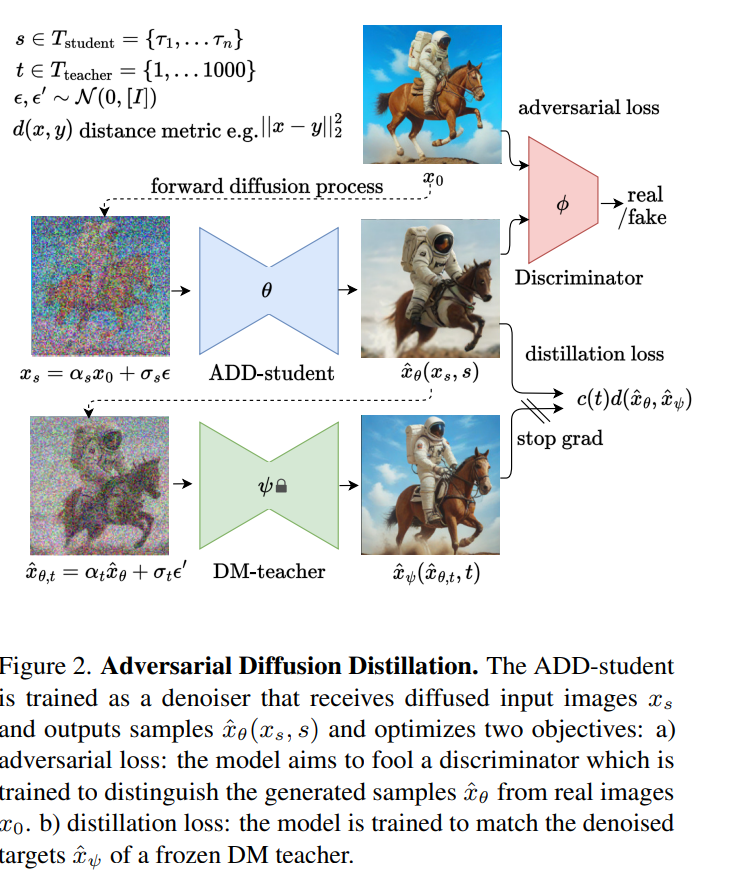









https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf

https://arxiv.org/pdf/2006.11239.pdf


#Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U einops datasets matplotlib tqdm

import math
import torch as torch
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import einsum
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.optim import Adam
from pathlib import Path

BATCH_SIZE=64

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
transform = tt.Compose([
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

print(dataset)
# create dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 325522324.18it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40868992.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 89658413.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4145925.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )


In [4]:
def show_batch(images):
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))

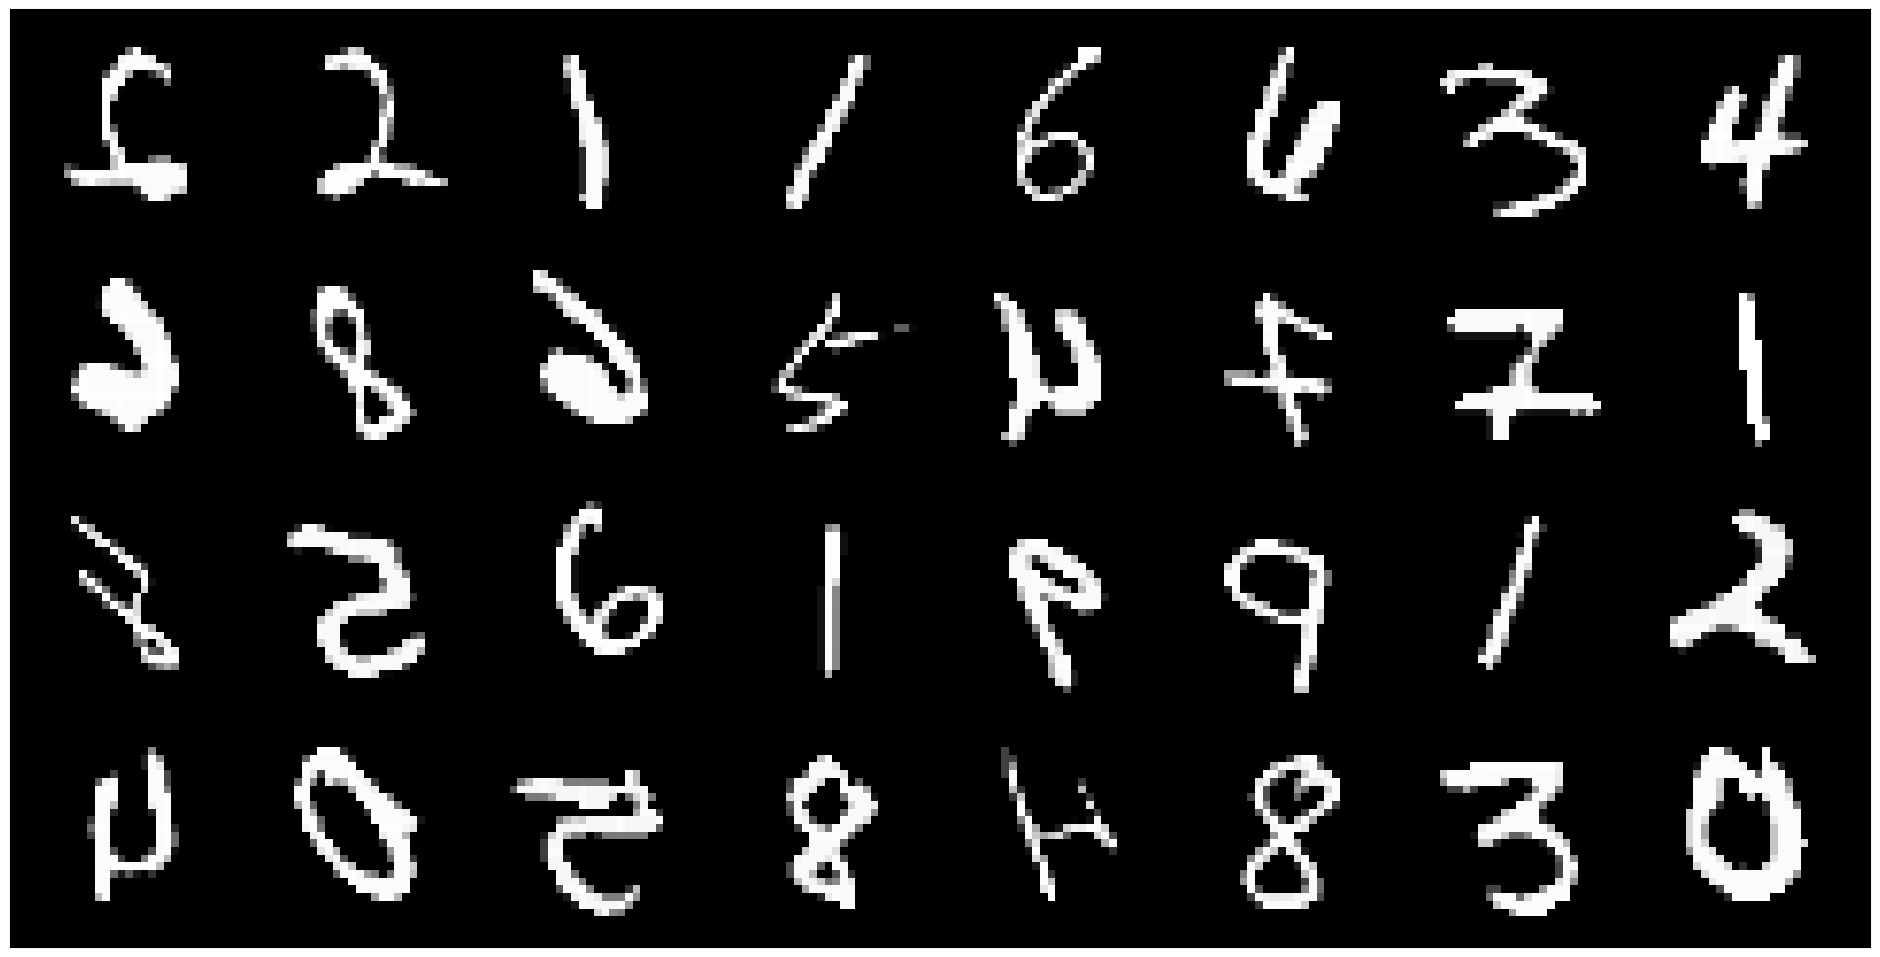

In [5]:
show_batch(next(iter(dataloader))[0])

In [6]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

timesteps = 800

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. -  betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [7]:
def show_tensor_image(image):
    reverse_transforms = tt.Compose([
        tt.Lambda(lambda t: (t + 1) / 2),
        tt.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        tt.Lambda(lambda t: t * 255.),
        tt.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tt.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


torch.Size([64, 1, 28, 28])


<ipython-input-8-f27da4a9ee29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


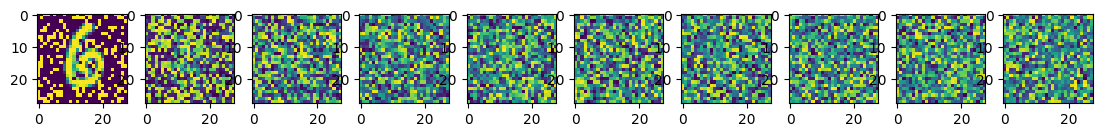

In [8]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
print(image.shape)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(1, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = q_sample(image, t)
    show_tensor_image(img)

# Diffusion Model

La UNet viene utilizzata per fare in modo che il modello impari solo le parti più importanti dell'immagini tralasciando i dettagli



##UNeT

In [9]:
#Utilities

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #concatenazione
        return embeddings

In [11]:
class UNet_Block(nn.Module):
  def __init__(self, dim_input, dim_output, groups=4):
    super().__init__()
    self.proj = nn.Conv2d(dim_input, dim_output, 3, padding = 1)
    self.normalization= nn.GroupNorm( groups, dim_output)
    self.act= nn.SiLU()

  def forward(self, x):
    x = self.proj(x)
    x = self.normalization(x)
    x = self.act(x)

    return x

class UNet_ResNet(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=4):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = UNet_Block(dim, dim_out, groups=groups)
        self.block2 = UNet_Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.num_heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        #batch, num_heads, dim_features, x, y
        #organizza le informazioni ottenute dalla proiezione lineare in q, k, e v nel formato appropriato
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k) #specifica come fare la moltiplicazione tra il vettore q (batch, num_heads, dim_features, index(i)) e k(batch, num_heads, dim_features, index(j))
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [13]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,
        with_time_emb=True,
        resnet_block_groups=4,
        convnext_mult=2,
    ):
        super().__init__()

        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #dim * [1,2,4,8]
        in_out = list(zip(dims[:-1], dims[1:]))  #dim * [1,2,4,8,4,2,1]

        block_klass = partial(UNet_ResNet, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),


                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

##Train

In [ ]:
image_size = 28
channels = 1
batch_size = 64

diffusion_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
diffusion_model.to(device)


Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

In [ ]:
epochs = 5

optimizer = Adam(diffusion_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      noise=torch.randn_like(batch)
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 200 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

    scheduler.step(loss)

Epoch: 0   Loss: 0.4891647696495056
Epoch: 0   Loss: 0.027346357703208923
Epoch: 0   Loss: 0.019389258697628975
Epoch: 0   Loss: 0.020027965307235718
Epoch: 0   Loss: 0.019901098683476448
Epoch: 1   Loss: 0.018754998221993446
Epoch: 1   Loss: 0.016845114529132843
Epoch: 1   Loss: 0.01827157288789749
Epoch: 1   Loss: 0.012433494441211224
Epoch: 1   Loss: 0.015111030079424381
Epoch: 2   Loss: 0.01423138752579689
Epoch: 2   Loss: 0.014834064058959484
Epoch: 2   Loss: 0.01794585771858692
Epoch: 2   Loss: 0.013135024346411228
Epoch: 2   Loss: 0.01291422639042139
Epoch: 3   Loss: 0.013524862006306648
Epoch: 3   Loss: 0.014234029687941074
Epoch: 3   Loss: 0.01427651196718216
Epoch: 3   Loss: 0.012183337472379208
Epoch: 3   Loss: 0.015160196460783482
Epoch: 4   Loss: 0.014730287715792656
Epoch: 4   Loss: 0.01311099249869585
Epoch: 4   Loss: 0.014458680525422096
Epoch: 4   Loss: 0.013238060288131237
Epoch: 4   Loss: 0.01423629466444254


In [ ]:
path = '/content/drive/MyDrive/diffusion_model.pth'

# Salva il modello
torch.save(diffusion_model.state_dict(), path)

##Generate new samples

In [14]:
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


def p_sample_loop(model,img, shape, timesteps):
    device = next(model.parameters()).device

    b = shape[0]
    imgs = []

    for i in reversed(range(0, timesteps)):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

def sample(model, img, image_size, timestep, batch_size=BATCH_SIZE, channels=1):
    return p_sample_loop(model, img,  shape=(batch_size, channels, image_size, image_size), timesteps=timestep)

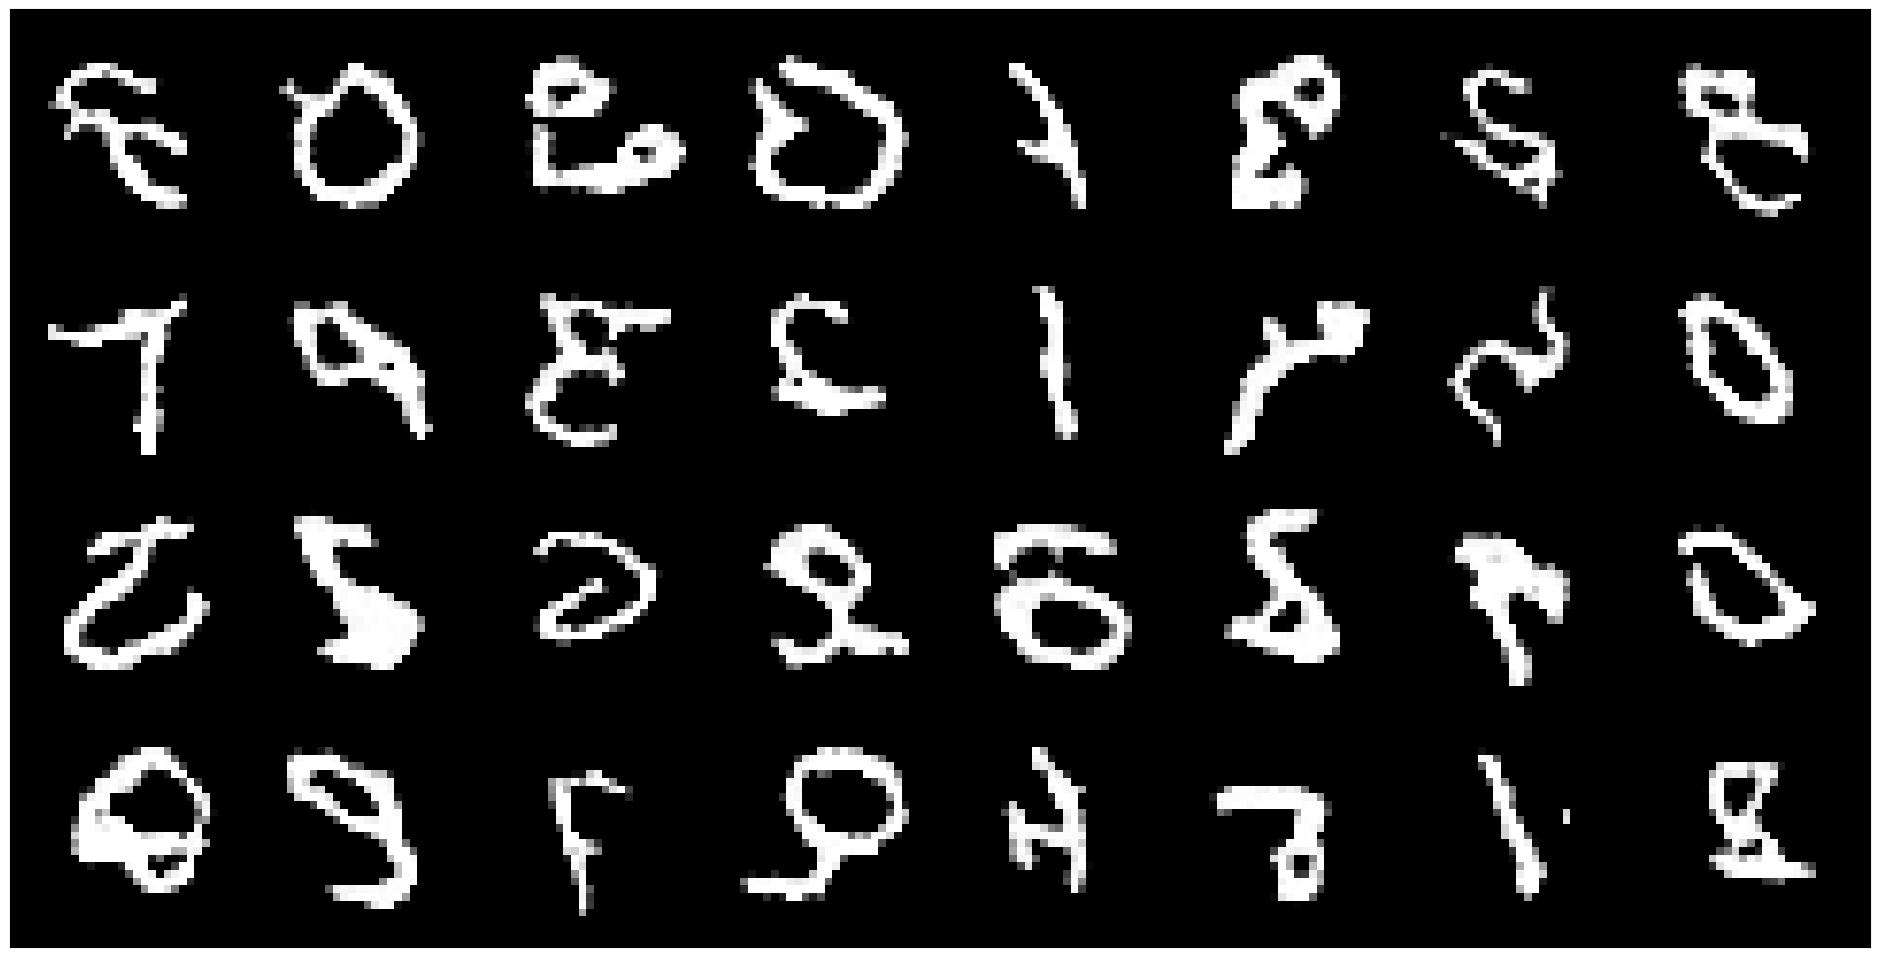

In [ ]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device)
  sample_data = sample(diffusion_model, pure_noise, image_size=image_size, timestep=800,  batch_size=BATCH_SIZE, channels=1)
  show_batch(sample_data[-1].cpu().detach())

# Discriminator

##ViT

In [15]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size,  emb_size = 64):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )
        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)

    def forward(self, x):
        x = self.projection(x)
        x = self.linear(x)
        return x


In [16]:
class DiscResidual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class DiscPreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


In [17]:
class DiscAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super(DiscAttention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [18]:
class ViT(nn.Module):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=1, patch_size = 7,  n_layers = 3,  img_size=28, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels, patch_size= patch_size,  emb_size = emb_dim)

    #self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(emb_dim, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      block = nn.Sequential(

          DiscResidual(DiscPreNorm(emb_dim, DiscAttention(emb_dim, num_heads))),

          DiscResidual(DiscPreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                  nn.LeakyReLU(),
                                                  nn.Dropout(dropout),
                                                  nn.Linear(hidden_dim, emb_dim),
                                                  nn.Dropout(dropout)
                                              )))
      )
      self.layers.append(block)

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim* (num_patches + 1)), nn.Linear(emb_dim* (num_patches + 1), out_dim))
    self.sigmoid = nn.Sigmoid()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      #images = self.patch_extraction(images)
      x = self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1),:]
      for layer in self.layers:
        x = layer(x)
      x = self.projection(x)
      return self.sigmoid(self.classification_head(x[:, :]))

losses = []
discriminator_model = ViT(64, 512, 1, 1).to(device)

##Training

In [ ]:
num_epochs=1
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)

for epoch in range(num_epochs):

    for step, batch in enumerate(dataloader):

        if step ==10:
          break

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch[0].shape[0],), device=device).long().to(device)

        noise=torch.randn_like(batch[0]).to(device) #crea rumore con la stessa dimensione del batch
        x_noisy = q_sample(x_start=batch[0].to(device), t=t, noise=noise)
        predicted_noise = diffusion_model(x_noisy[0], t)
        with torch.no_grad():
          fake_data = sample( diffusion_model, x_noisy[0], image_size, timestep=timesteps,  batch_size=BATCH_SIZE, channels=channels)

        # Preparazione dei dati
        real_data = batch

        # Etichette per esempi reali e falsi
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        if real_data[0].shape[0] == BATCH_SIZE:
          output_real = discriminator_model(real_data[0].to(device))
          loss_real = criterion(output_real, real_labels)
        else:
          break

        # Forward pass per esempi falsi
        output_fake = discriminator_model(fake_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
        loss_fake = criterion(output_fake, fake_labels)

        # Calcolo totale della loss
        total_loss = loss_real + loss_fake
        print(loss_real)
        print(loss_fake)
        print("Epoch: " + str(epoch)+ "   Loss:", total_loss)

        total_loss.backward()
        optimizer.step()

tensor(0.6385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4596, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4194, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>

In [ ]:
path = '/content/drive/MyDrive/discriminator_model.pth'

# Salva il modello
torch.save(discriminator_model.state_dict(), path)

# Full Train

In [19]:
image_size = 28
channels = 1
batch_size = 64
student_timesteps = 10
teacher_timesteps= 400

disc_loss = nn.BCELoss()
disc_loss2 = nn.BCELoss()
dis_loss = nn.MSELoss()
l = 2.5
regularization_term = 2

In [66]:
# path to take the pretrained models
diffusion_path = '/content/drive/MyDrive/diffusion_model.pth'
discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'
student_path = '/content/drive/MyDrive/student_model.pth'


# Load the teacher_model
teacher_model = Unet(  dim=image_size,  channels=channels,  dim_mults=(1, 2, 4,))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Load the discriminator_model
discriminator_model = ViT(64, 512, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.train()
discriminator_model.to(device)

# Load the teacher_model
student_model = Unet( dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
student_model.load_state_dict(torch.load(student_path))#DIFFUSION PATH
student_model.train()
student_model.to(device)

Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

Il training consiste nel:


*   Fase 1: trainare con poco noise (0, timestep) lo student e il teacher partendo dalla stessa immagine con aggiunto rumore in modo che il teacher accompagni lo student nella prima fase di training
*   Fase 2: aumentare il rumore (0, timestep *2)
*   Fase 3: fare in modo che il teacher prenda in ingresso l'output dello student con poco rumore (0, timestep) e invece il rumore tra dati reali e input dello student sia più alto(timestep, timestep*2)
*   Fase 4: aumentare il rumore tra output dello student e input del teacher (0, timestep*2)
*   Fase 5: Dare in ingresso allo student rumore puro e inserire abbastanza rumore (0, timestep*2) tra lo student e il teacher in modo da evitare mode collapse





Epoch: 0  Adversarial Loss:tensor(1.4659, device='cuda:0', grad_fn=<AddBackward0>)


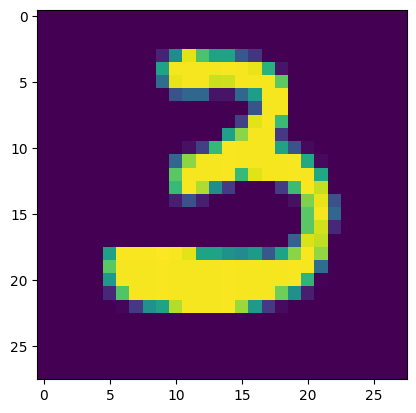

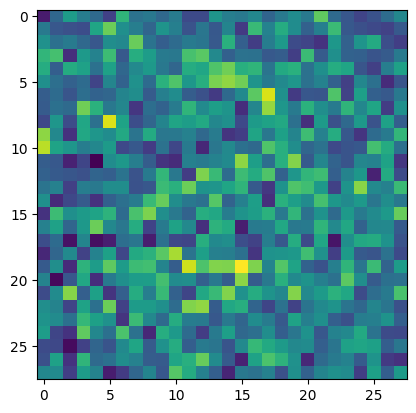

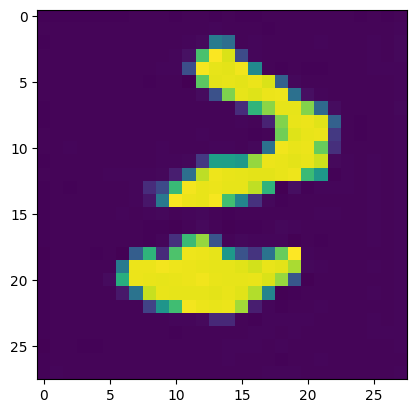

Epoch: 0   Loss: tensor(3.3734, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(1.0542, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.7378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(3.0199, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.9388, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.6730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(2.7846, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.8427, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(2

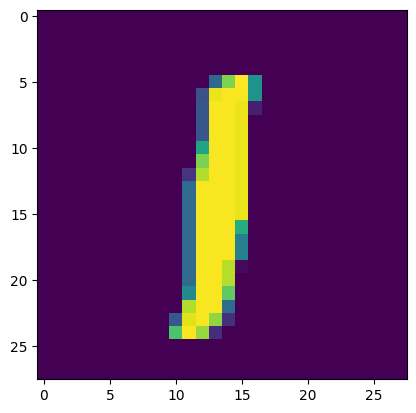

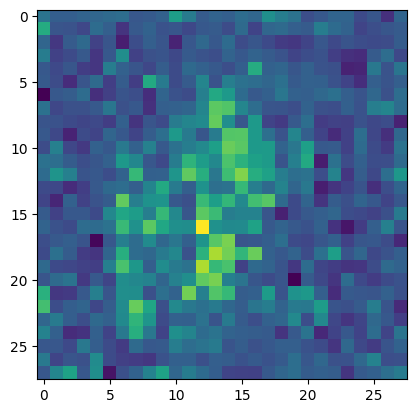

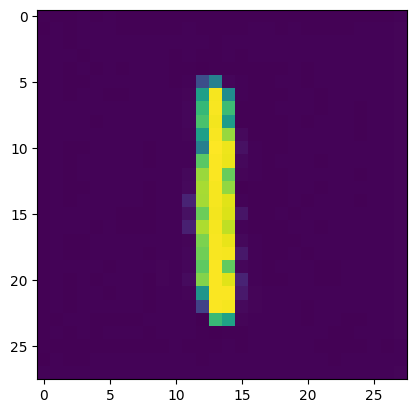

Epoch: 1   Loss: tensor(0.9382, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3284, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.4806, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.8347, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2873, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.4806, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.7645, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2572, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.4806, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

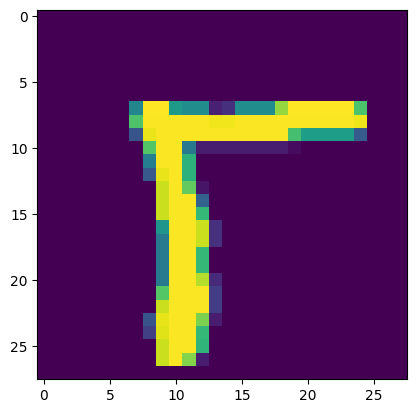

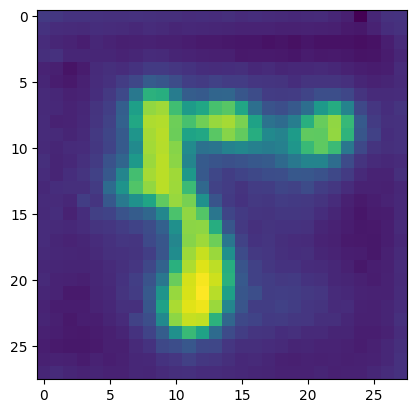

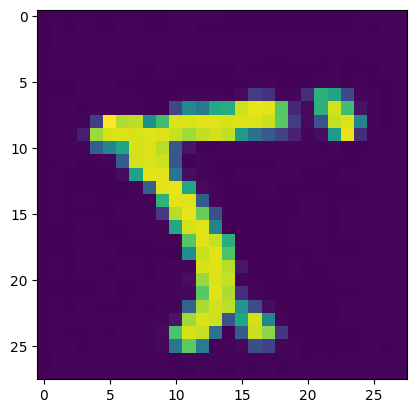

Epoch: 2   Loss: tensor(0.4768, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1753, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3891, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2   Loss: tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1914, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3891, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2   Loss: tensor(0.5252, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1923, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3891, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2   Loss: tensor(0

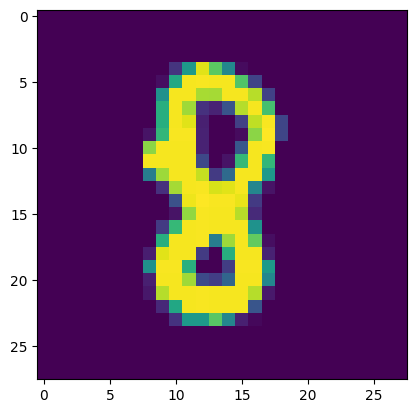

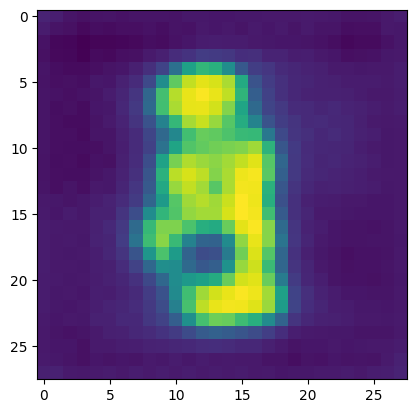

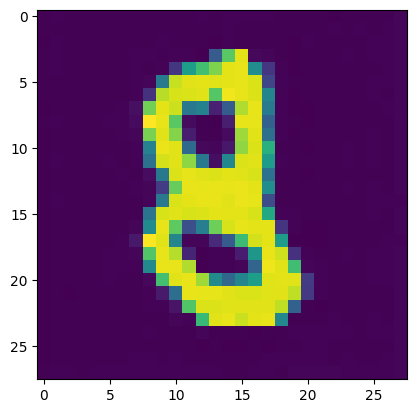

Epoch: 3   Loss: tensor(0.4342, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1638, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.3361, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3   Loss: tensor(0.4731, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1784, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.3361, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3   Loss: tensor(0.4684, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1761, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(3.3361, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3   Loss: tensor(0

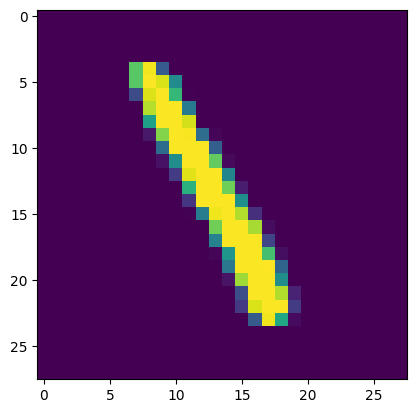

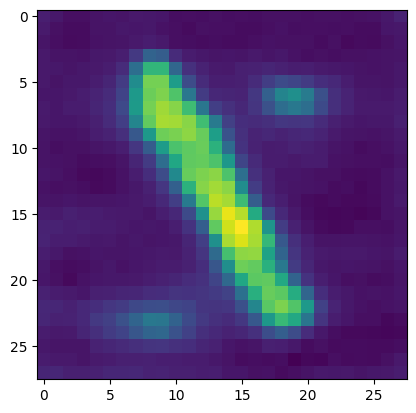

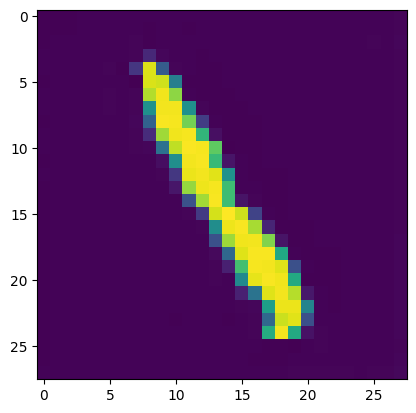

Epoch: 4   Loss: tensor(0.4062, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1529, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.7870, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4   Loss: tensor(0.3994, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1494, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.7870, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4   Loss: tensor(0.4410, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1655, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.7870, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4   Loss: tensor(0

In [ ]:
torch.cuda.empty_cache()
epochs = 5

student_optimizer = Adam(student_model.parameters(), lr=1e-3, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=2, factor=0.05)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=2, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps-1, teacher_timesteps, (batch_size,), device=device).long()
      t_teacher = torch.randint(teacher_timesteps-1, teacher_timesteps, (batch_size,), device=device).long()

      noise = torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_student[0], image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      if step % 10 == 0:
        #show the results
        random_index = random.randint(0, 63)
        image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)
        image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
        image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
        plt.imshow(image_data0)
        plt.show()
        plt.imshow(image_data1)
        plt.show()
        plt.imshow(image_data3)
        plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])
      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

Epoch: 0  Adversarial Loss:tensor(2.4807, device='cuda:0', grad_fn=<AddBackward0>)


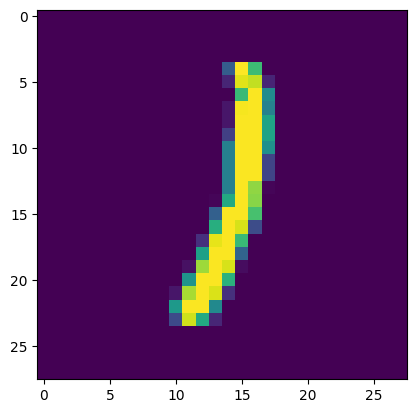

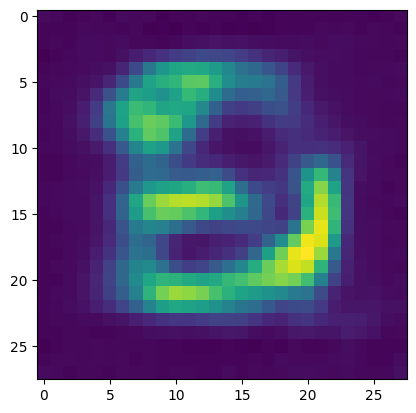

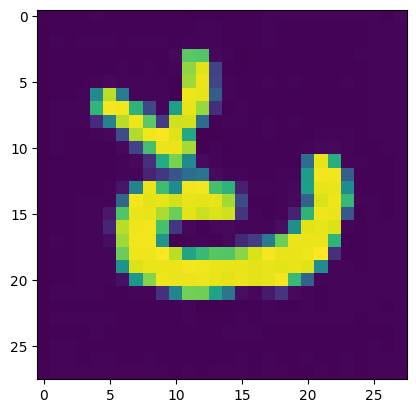

Epoch: 0  Total Loss: tensor(0.7179, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2403, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.4807, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  Total Loss: tensor(0.7852, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2596, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.4807, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  Total Loss: tensor(0.7968, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2646, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.4807, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  

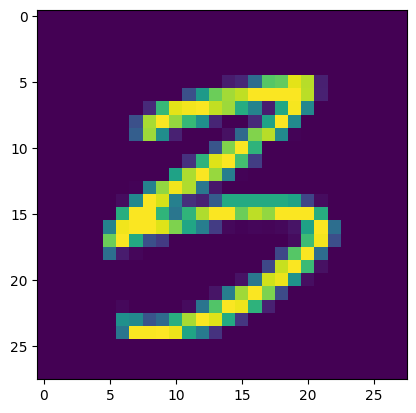

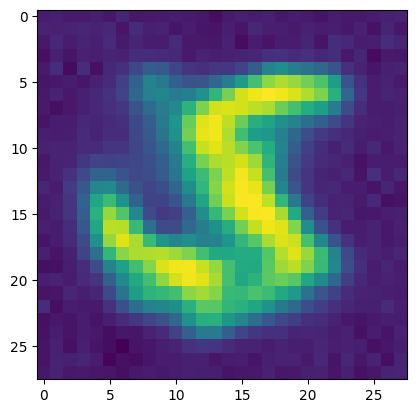

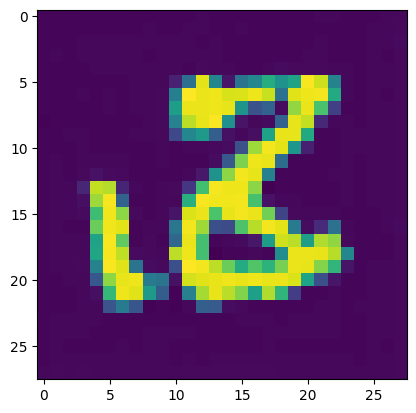

Epoch: 1  Total Loss: tensor(0.7238, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2419, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3652, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  Total Loss: tensor(0.7358, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2434, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3652, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  Total Loss: tensor(0.7658, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2546, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3652, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  

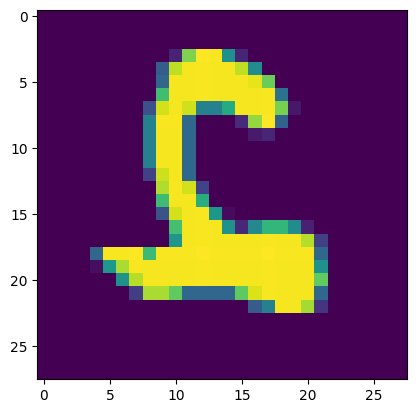

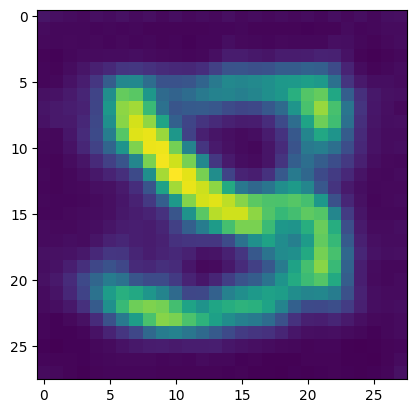

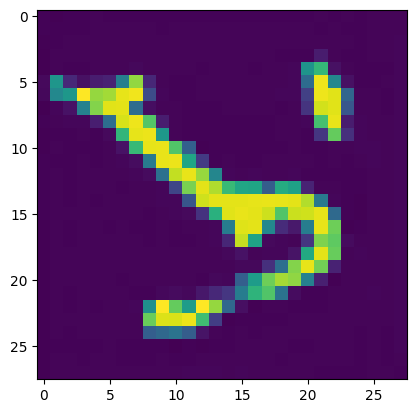

Epoch: 2  Total Loss: tensor(0.7295, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2447, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3427, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  Total Loss: tensor(0.7282, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2425, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3427, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  Total Loss: tensor(0.7354, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2451, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3427, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  

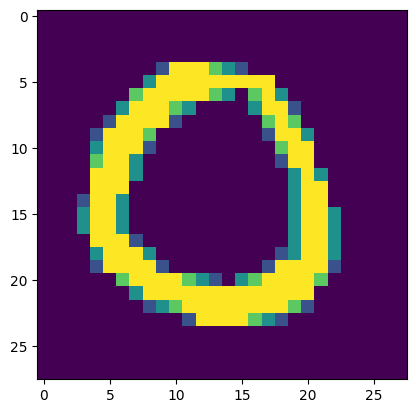

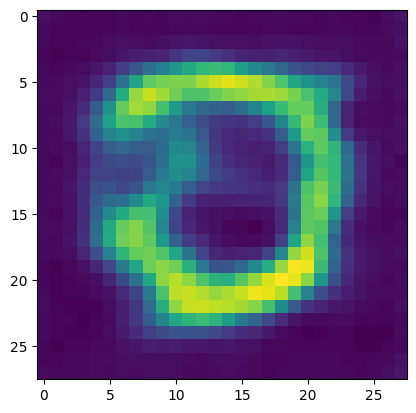

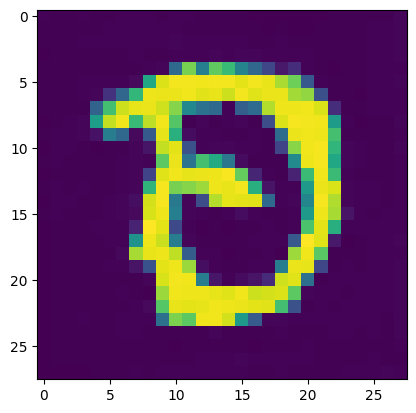

Epoch: 3  Total Loss: tensor(0.6922, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2316, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3444, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  Total Loss: tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2406, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3444, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  Total Loss: tensor(0.7311, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2455, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3444, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  

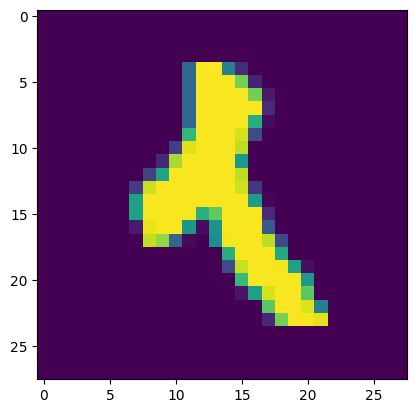

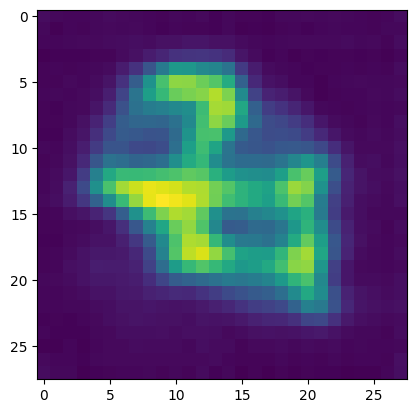

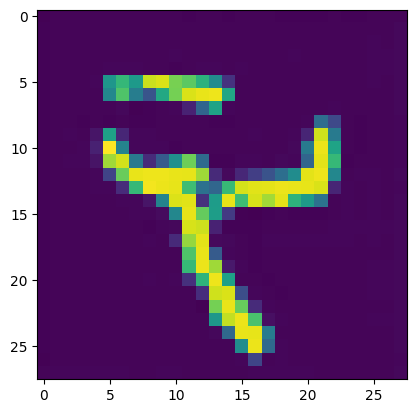

Epoch: 4  Total Loss: tensor(0.7101, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2410, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(2.3499, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  Total Loss: tensor(0.6901, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2316, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(2.3499, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  Total Loss: tensor(0.6999, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2356, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(2.3499, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  

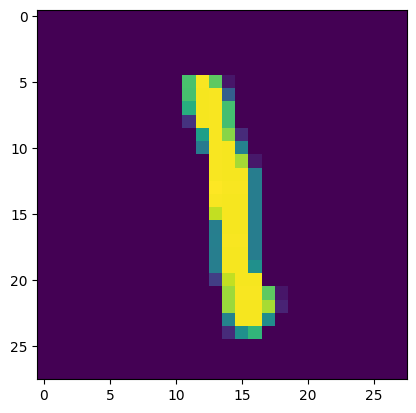

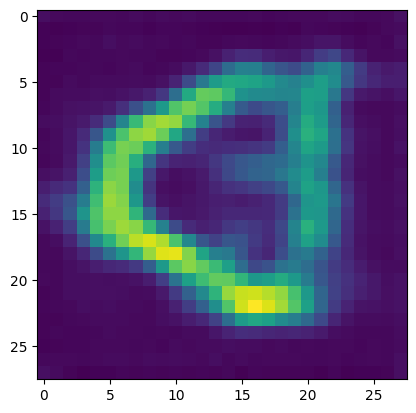

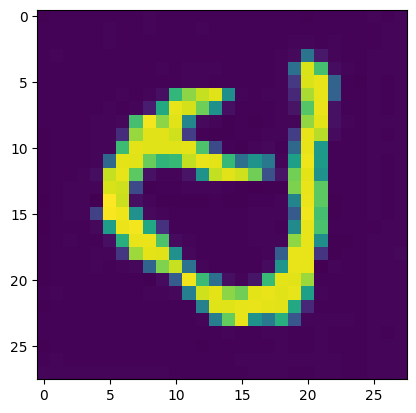

Epoch: 5  Total Loss: tensor(0.7097, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2435, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(2.4140, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  Total Loss: tensor(0.7054, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2413, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(2.4140, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  Total Loss: tensor(0.6512, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2196, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(2.4140, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  

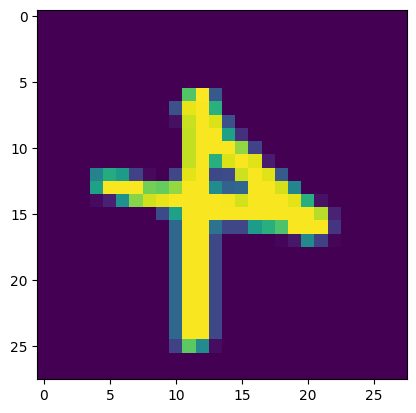

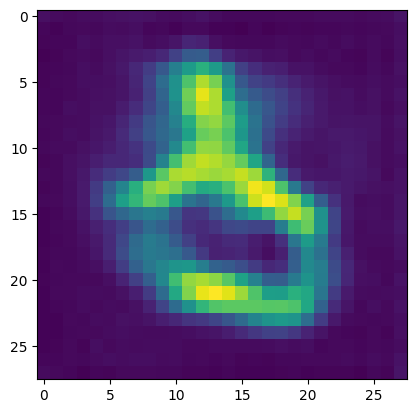

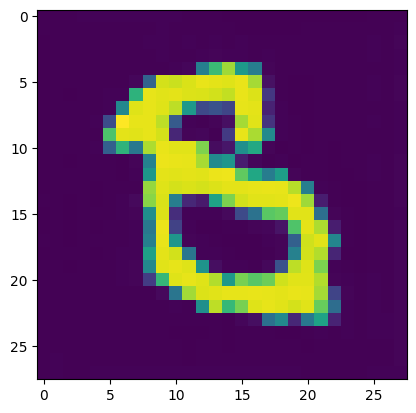

Epoch: 6  Total Loss: tensor(0.6686, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2265, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(2.4585, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  Total Loss: tensor(0.6677, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2279, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(2.4585, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  Total Loss: tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2171, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(2.4585, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  

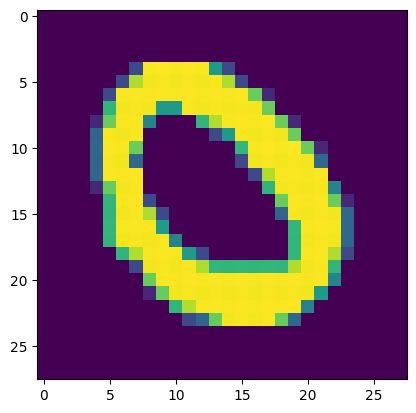

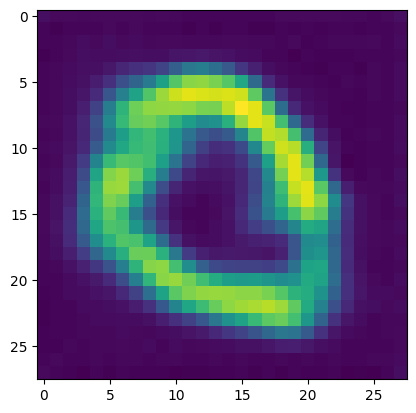

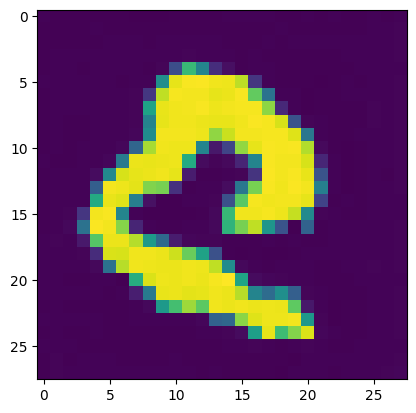

Epoch: 7  Total Loss: tensor(0.6850, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2334, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(2.4565, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  Total Loss: tensor(0.6577, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2229, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(2.4565, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  Total Loss: tensor(0.6994, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2397, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(2.4565, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  

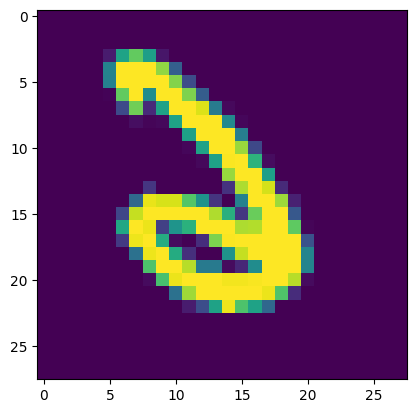

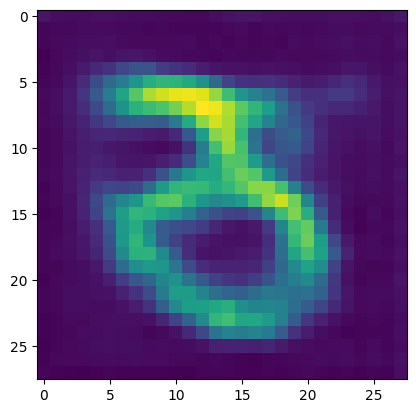

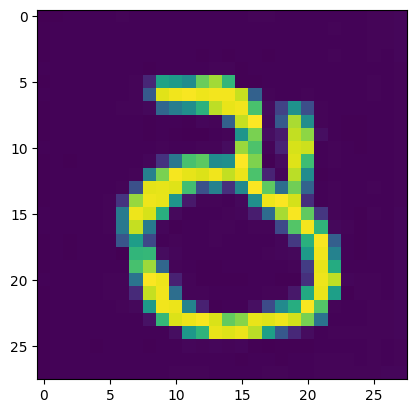

Epoch: 8  Total Loss: tensor(0.6858, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2324, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(2.4390, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  Total Loss: tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2379, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(2.4390, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  Total Loss: tensor(0.7037, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2409, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(2.4390, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  

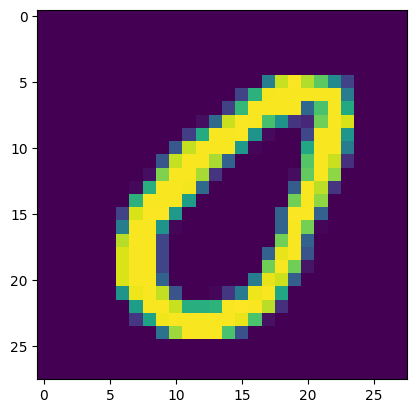

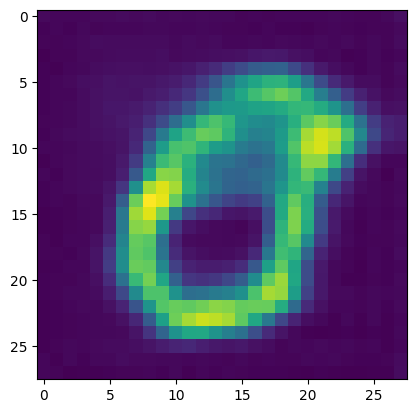

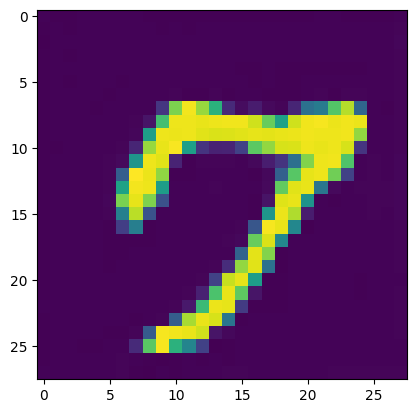

Epoch: 9  Total Loss: tensor(0.6672, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2272, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.4758, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  Total Loss: tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2359, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.4758, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  Total Loss: tensor(0.6647, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2250, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.4758, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  

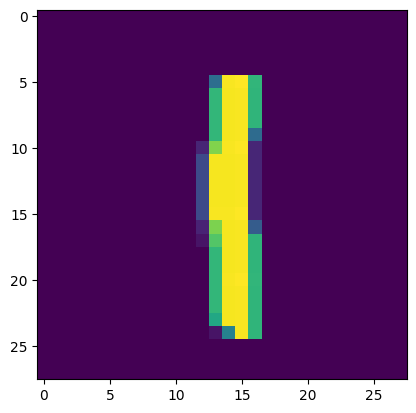

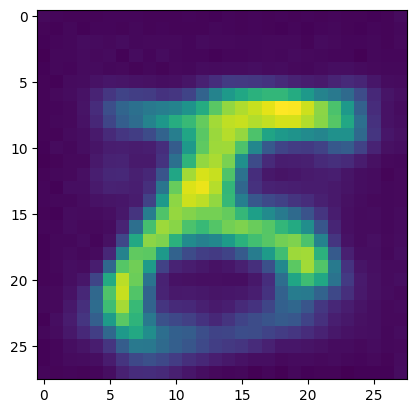

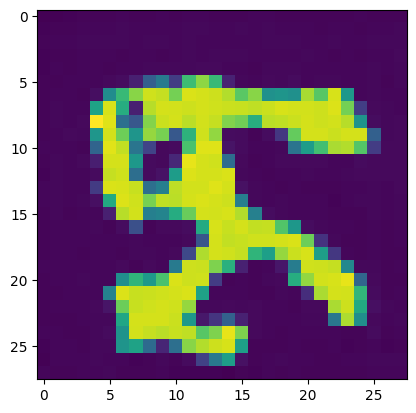

Epoch: 10  Total Loss: tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2292, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(2.4478, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10  Total Loss: tensor(0.6366, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2130, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(2.4478, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10  Total Loss: tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2157, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(2.4478, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

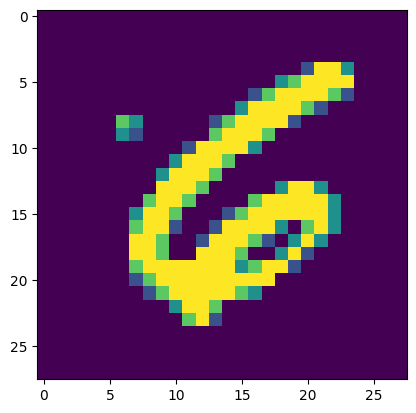

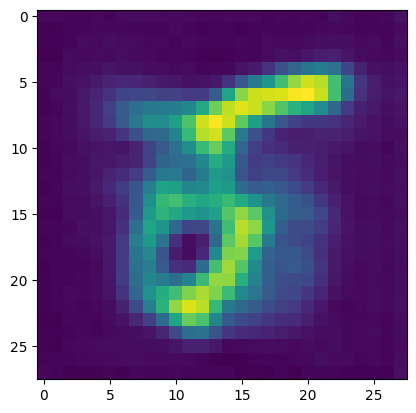

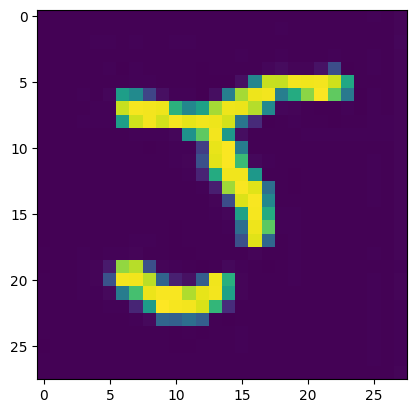

Epoch: 11  Total Loss: tensor(0.6333, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2125, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(2.4274, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11  Total Loss: tensor(0.6946, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2363, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(2.4274, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11  Total Loss: tensor(0.7028, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2398, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(2.4274, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

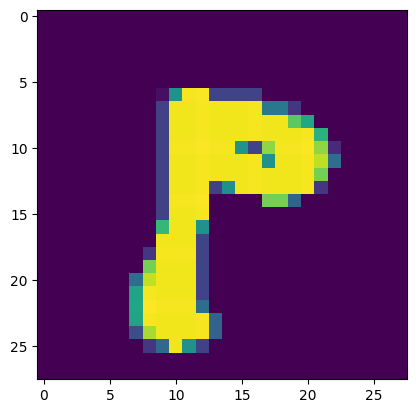

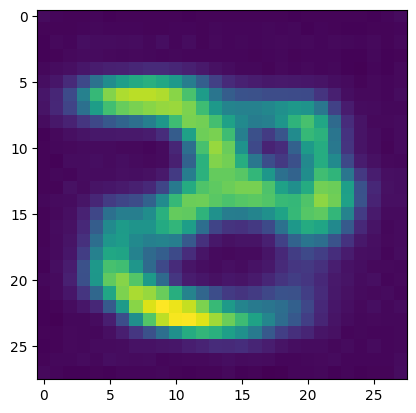

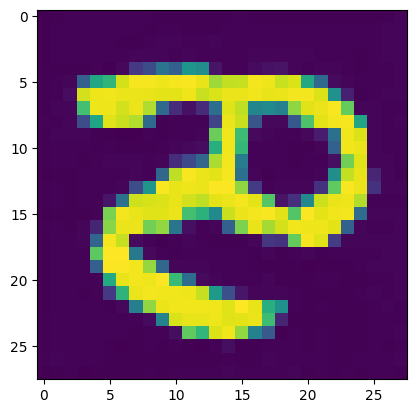

Epoch: 12  Total Loss: tensor(0.6807, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2310, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(2.4332, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 12  Total Loss: tensor(0.6549, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2211, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(2.4332, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 12  Total Loss: tensor(0.6757, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2306, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(2.4332, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

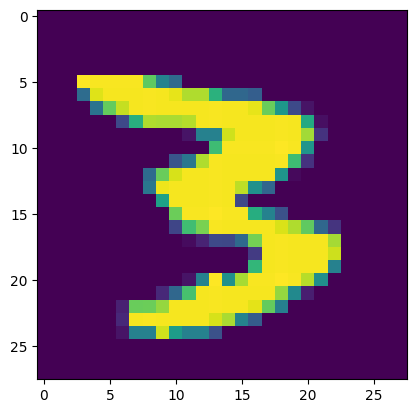

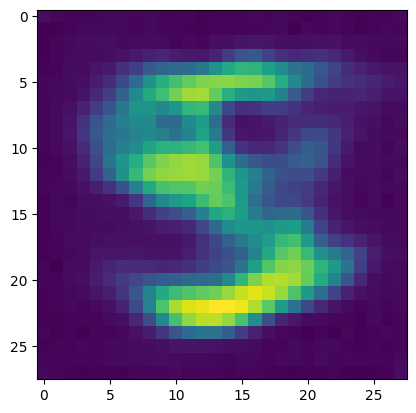

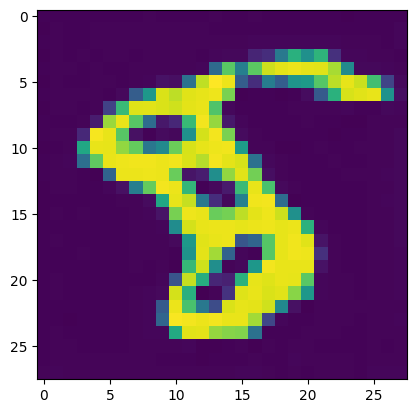

Epoch: 13  Total Loss: tensor(0.6474, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2178, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(2.4504, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 13  Total Loss: tensor(0.7006, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2398, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(2.4504, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 13  Total Loss: tensor(0.6232, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2081, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(2.4504, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

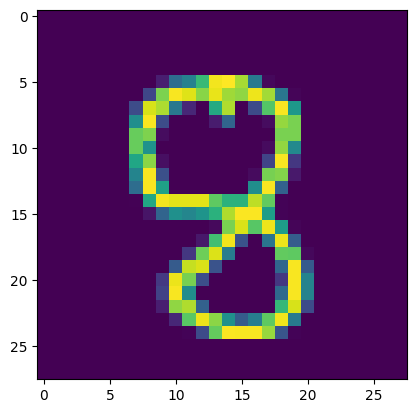

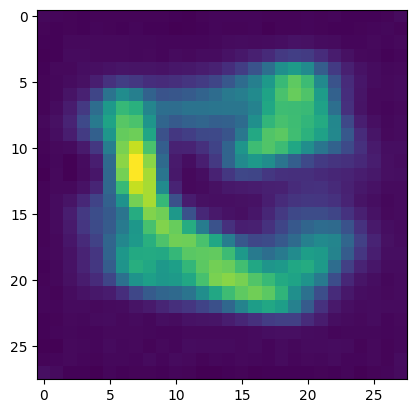

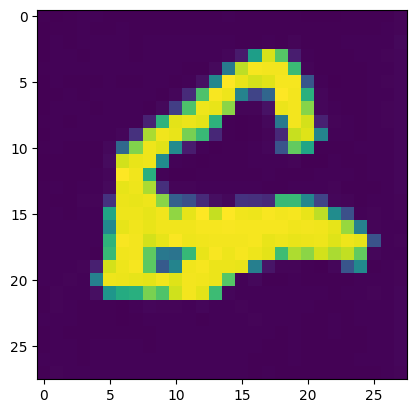

Epoch: 14  Total Loss: tensor(0.7015, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2399, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(2.4753, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 14  Total Loss: tensor(0.6667, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2270, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(2.4753, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 14  Total Loss: tensor(0.7268, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2492, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(2.4753, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

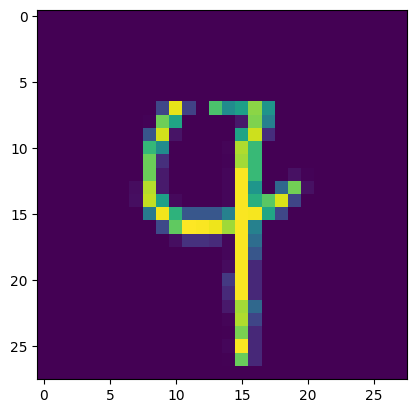

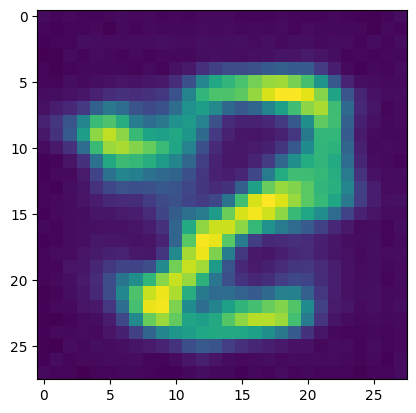

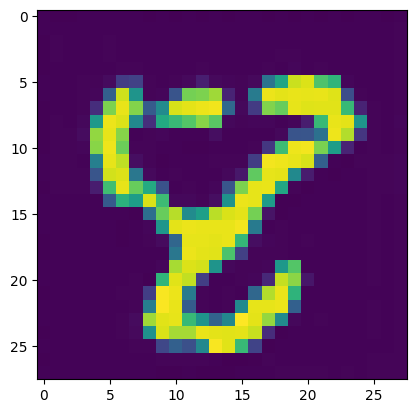

Epoch: 15  Total Loss: tensor(0.6687, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2271, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 15  Adversarial Loss:tensor(2.4555, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 15  Total Loss: tensor(0.6482, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2189, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 15  Adversarial Loss:tensor(2.4555, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 15  Total Loss: tensor(0.6840, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2336, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 15  Adversarial Loss:tensor(2.4555, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

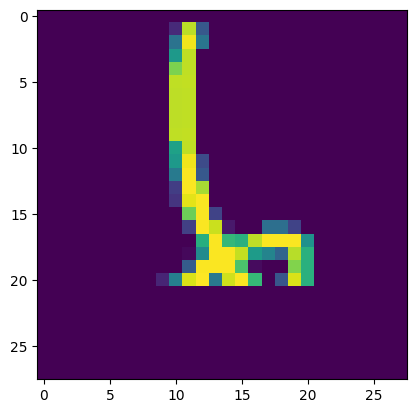

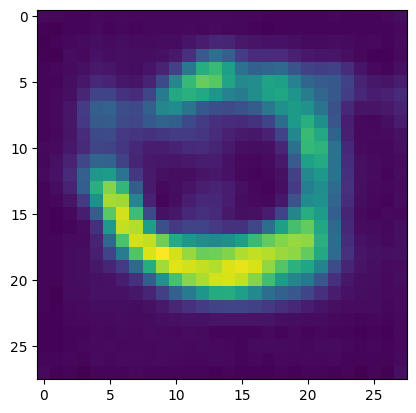

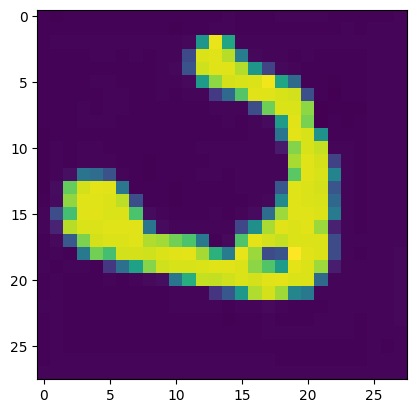

Epoch: 16  Total Loss: tensor(0.6522, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2210, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 16  Adversarial Loss:tensor(2.4838, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 16  Total Loss: tensor(0.6962, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2378, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 16  Adversarial Loss:tensor(2.4838, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 16  Total Loss: tensor(0.7083, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2421, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 16  Adversarial Loss:tensor(2.4838, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

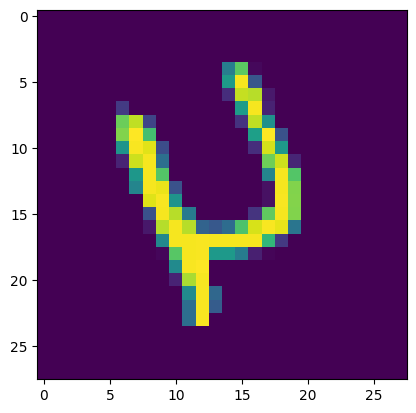

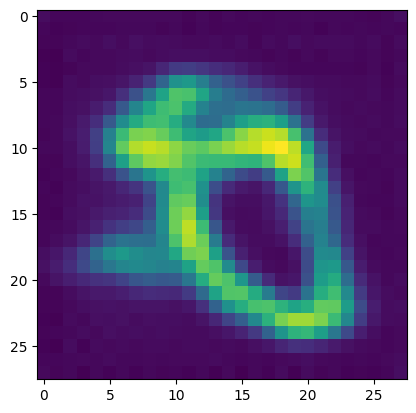

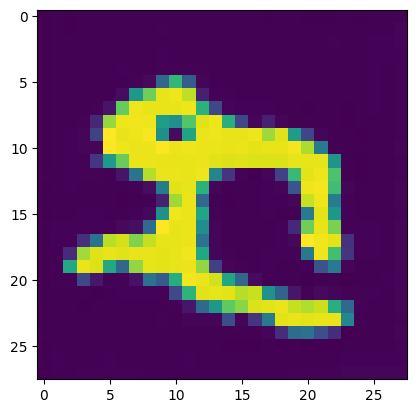

Epoch: 17  Total Loss: tensor(0.6592, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2234, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 17  Adversarial Loss:tensor(2.4889, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 17  Total Loss: tensor(0.6606, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2232, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 17  Adversarial Loss:tensor(2.4889, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 17  Total Loss: tensor(0.6496, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2193, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 17  Adversarial Loss:tensor(2.4889, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

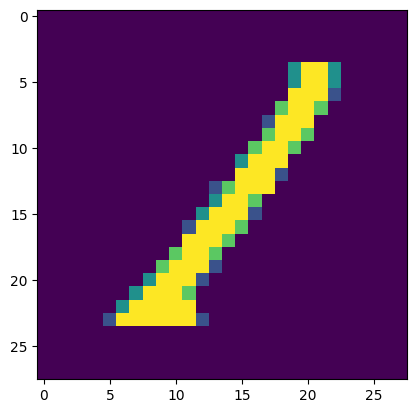

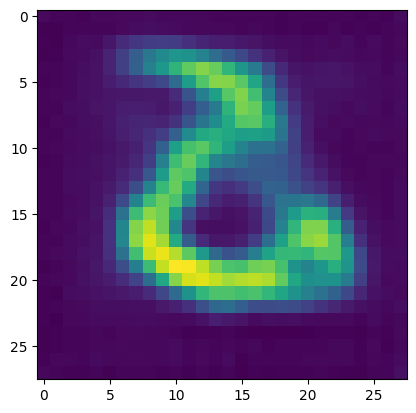

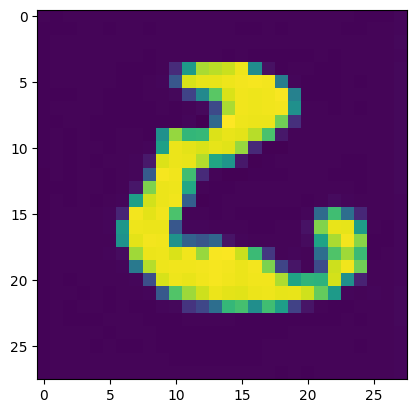

Epoch: 18  Total Loss: tensor(0.6786, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2302, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 18  Adversarial Loss:tensor(2.4404, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 18  Total Loss: tensor(0.7079, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2427, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 18  Adversarial Loss:tensor(2.4404, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 18  Total Loss: tensor(0.6770, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2299, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 18  Adversarial Loss:tensor(2.4404, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

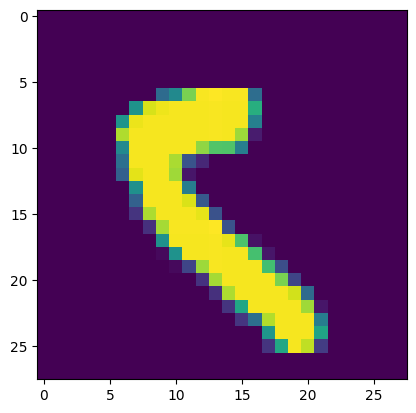

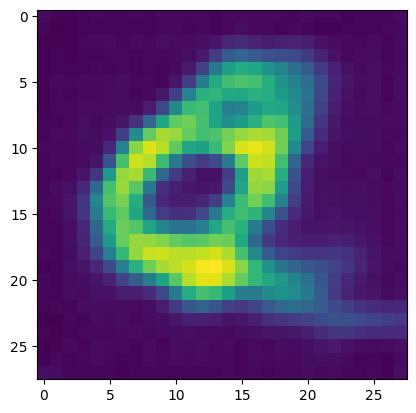

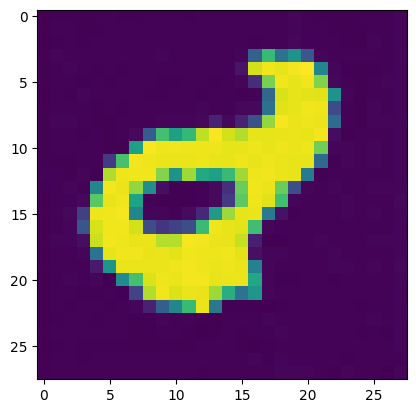

Epoch: 19  Total Loss: tensor(0.6718, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2281, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 19  Adversarial Loss:tensor(2.4536, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 19  Total Loss: tensor(0.6561, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2220, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 19  Adversarial Loss:tensor(2.4536, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 19  Total Loss: tensor(0.6593, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2236, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 19  Adversarial Loss:tensor(2.4536, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

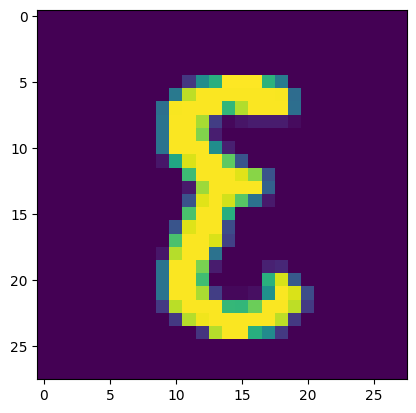

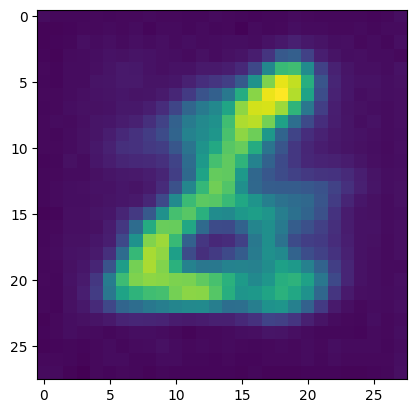

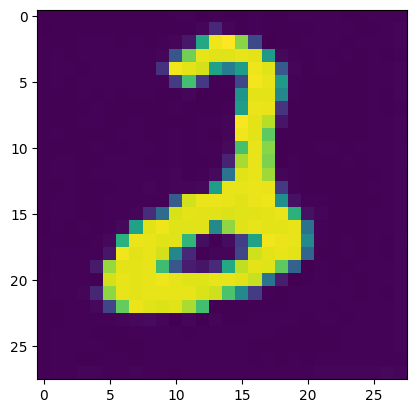

Epoch: 20  Total Loss: tensor(0.7344, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2536, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 20  Adversarial Loss:tensor(2.4585, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 20  Total Loss: tensor(0.6759, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2301, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 20  Adversarial Loss:tensor(2.4585, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 20  Total Loss: tensor(0.6755, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2297, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 20  Adversarial Loss:tensor(2.4585, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

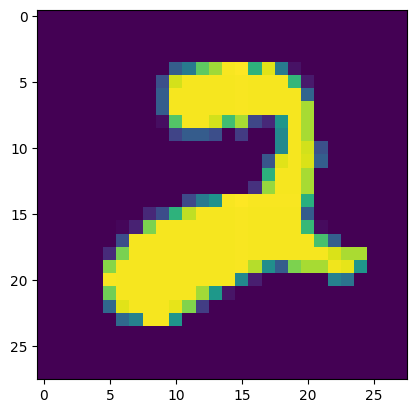

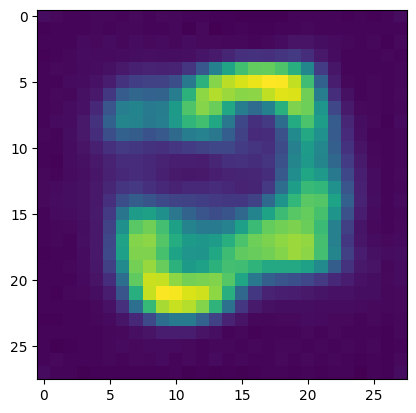

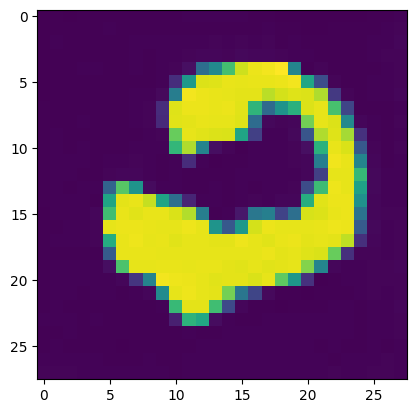

Epoch: 21  Total Loss: tensor(0.6582, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2223, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 21  Adversarial Loss:tensor(2.4516, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 21  Total Loss: tensor(0.6711, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2287, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 21  Adversarial Loss:tensor(2.4516, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 21  Total Loss: tensor(0.6644, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2262, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 21  Adversarial Loss:tensor(2.4516, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

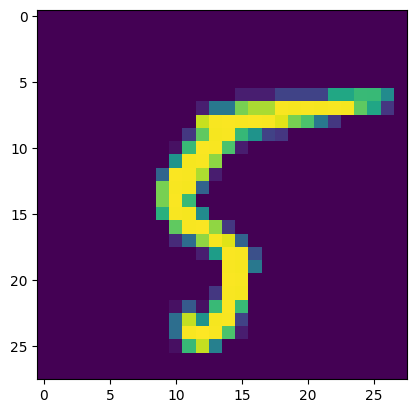

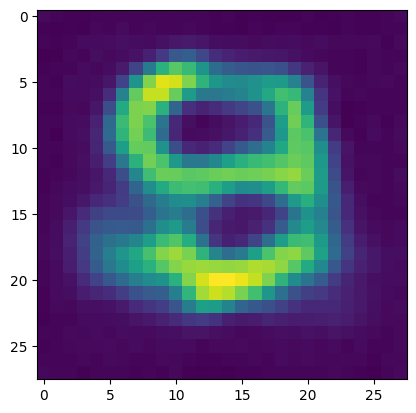

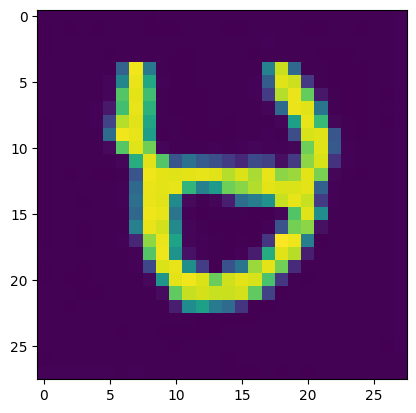

Epoch: 22  Total Loss: tensor(0.7070, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2418, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 22  Adversarial Loss:tensor(2.4406, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 22  Total Loss: tensor(0.6909, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2360, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 22  Adversarial Loss:tensor(2.4406, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 22  Total Loss: tensor(0.6540, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2218, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 22  Adversarial Loss:tensor(2.4406, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

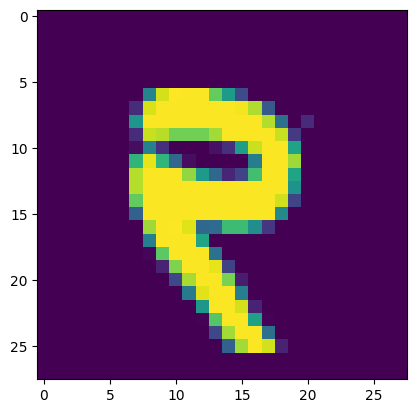

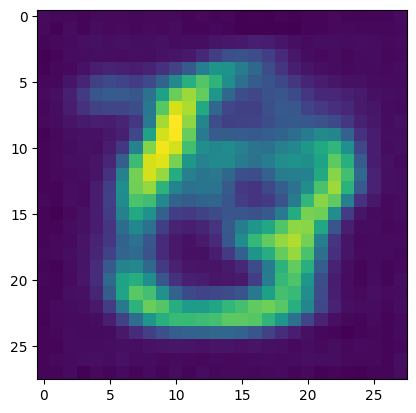

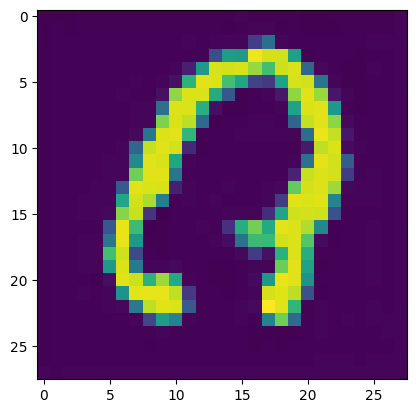

Epoch: 23  Total Loss: tensor(0.6534, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2207, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 23  Adversarial Loss:tensor(2.4521, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 23  Total Loss: tensor(0.6751, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2309, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 23  Adversarial Loss:tensor(2.4521, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 23  Total Loss: tensor(0.6986, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2393, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 23  Adversarial Loss:tensor(2.4521, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

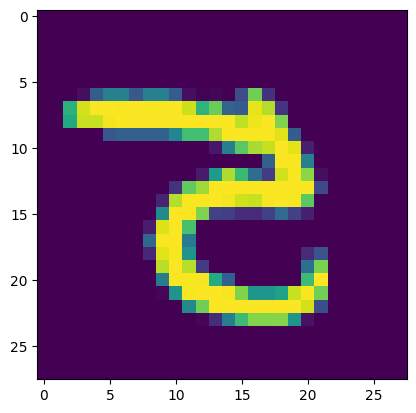

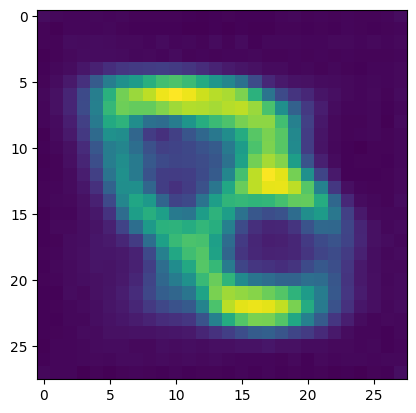

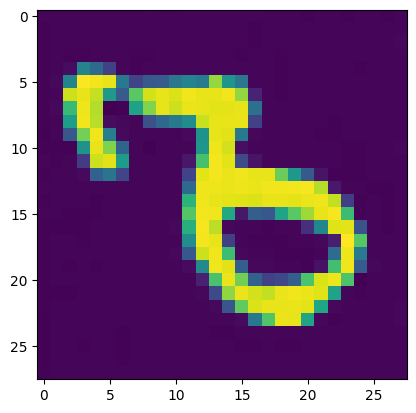

Epoch: 24  Total Loss: tensor(0.6702, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2271, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 24  Adversarial Loss:tensor(2.4560, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 24  Total Loss: tensor(0.7140, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2448, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 24  Adversarial Loss:tensor(2.4560, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 24  Total Loss: tensor(0.6514, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2202, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 24  Adversarial Loss:tensor(2.4560, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

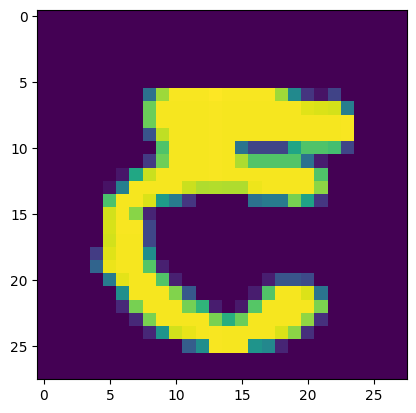

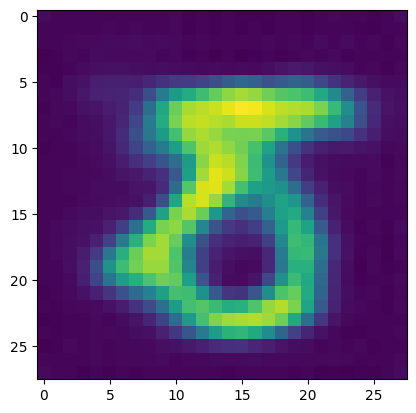

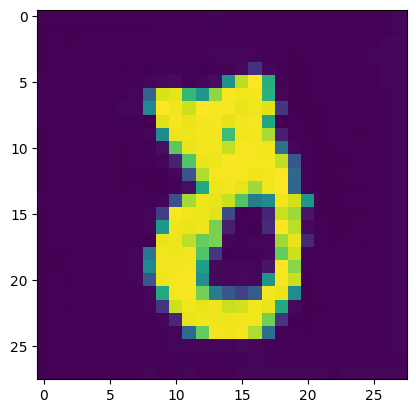

Epoch: 25  Total Loss: tensor(0.6844, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2334, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 25  Adversarial Loss:tensor(2.4545, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 25  Total Loss: tensor(0.6676, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2267, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 25  Adversarial Loss:tensor(2.4545, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 25  Total Loss: tensor(0.6452, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2172, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 25  Adversarial Loss:tensor(2.4545, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

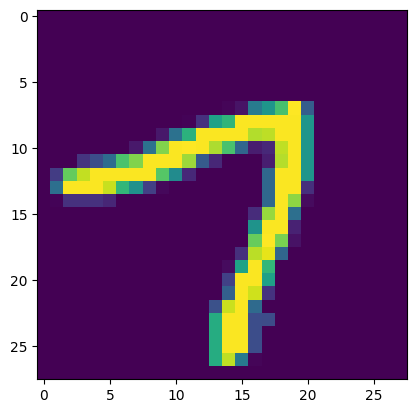

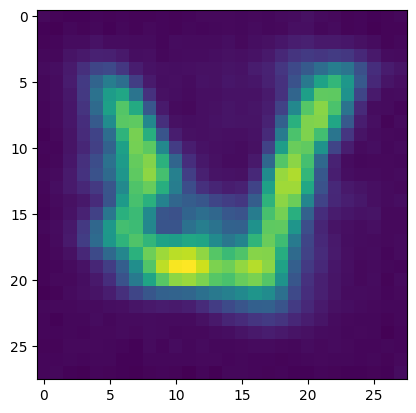

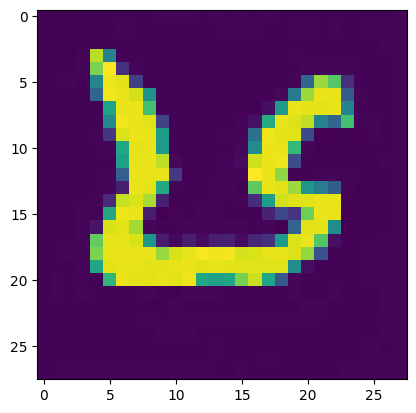

Epoch: 26  Total Loss: tensor(0.6999, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2392, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 26  Adversarial Loss:tensor(2.4527, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 26  Total Loss: tensor(0.6790, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2308, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 26  Adversarial Loss:tensor(2.4527, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 26  Total Loss: tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2321, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 26  Adversarial Loss:tensor(2.4527, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

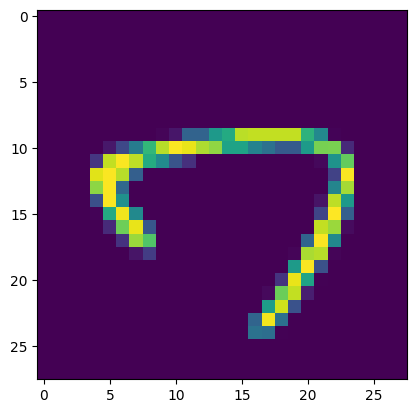

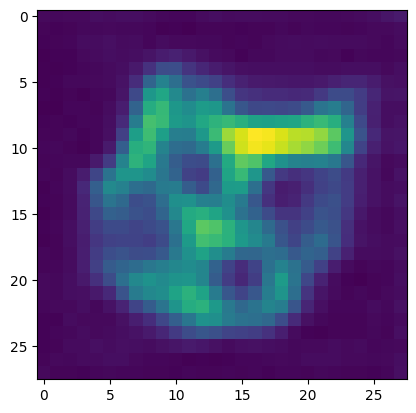

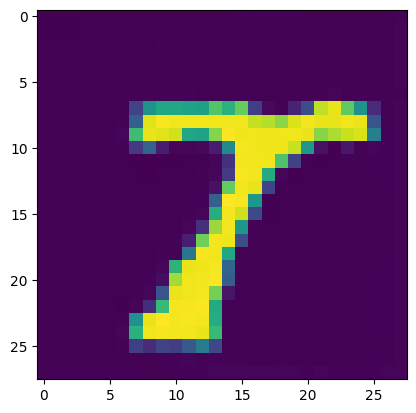

Epoch: 27  Total Loss: tensor(0.6804, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2320, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 27  Adversarial Loss:tensor(2.4407, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 27  Total Loss: tensor(0.6986, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2396, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 27  Adversarial Loss:tensor(2.4407, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 27  Total Loss: tensor(0.6797, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2309, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 27  Adversarial Loss:tensor(2.4407, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

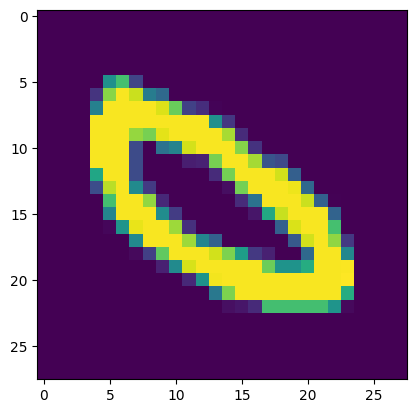

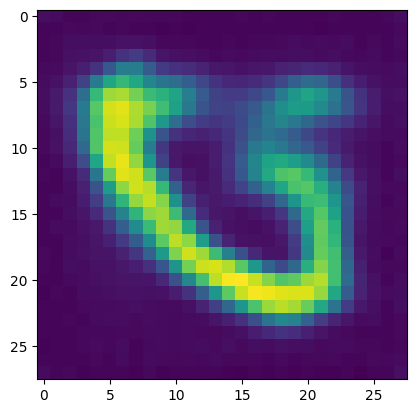

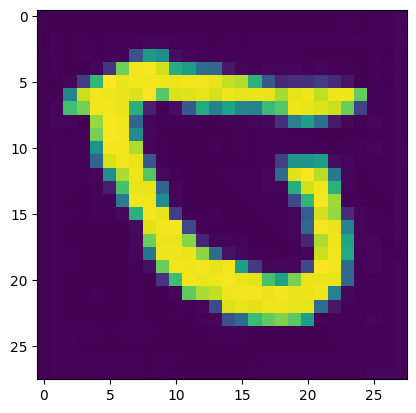

Epoch: 28  Total Loss: tensor(0.6698, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2274, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 28  Adversarial Loss:tensor(2.4338, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 28  Total Loss: tensor(0.6665, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2273, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 28  Adversarial Loss:tensor(2.4338, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 28  Total Loss: tensor(0.6634, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2249, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 28  Adversarial Loss:tensor(2.4338, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

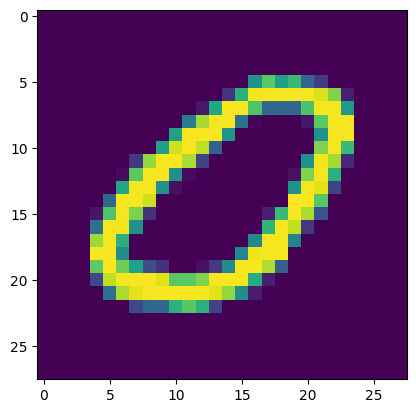

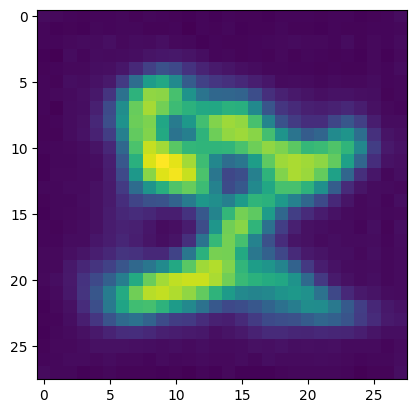

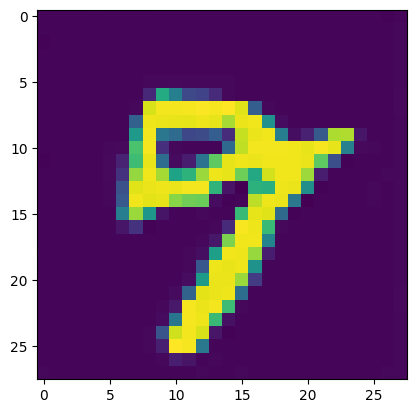

Epoch: 29  Total Loss: tensor(0.6571, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2221, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 29  Adversarial Loss:tensor(2.4419, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 29  Total Loss: tensor(0.7094, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2430, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 29  Adversarial Loss:tensor(2.4419, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 29  Total Loss: tensor(0.6696, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2273, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 29  Adversarial Loss:tensor(2.4419, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

In [39]:
torch.cuda.empty_cache()
epochs = 30

student_optimizer = Adam(student_model.parameters(), lr=1e-3, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=2, factor=0.05)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=2, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps, teacher_timesteps*2, (batch_size,), device=device).long()
      t_teacher = torch.randint(teacher_timesteps, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0], image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      if step % 10 == 0:
          random_index = random.randint(0, 63)
          #show the results
          image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)
          image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
          image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
          plt.imshow(image_data0)
          plt.show()
          plt.imshow(image_data1)
          plt.show()
          plt.imshow(image_data3)
          plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "  Total Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

In [40]:
discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'
student_path = '/content/drive/MyDrive/student_model.pth'

# Salva il modello
torch.save(discriminator_model.state_dict(), discriminator_path)
torch.save(student_model.state_dict(), student_path)

Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


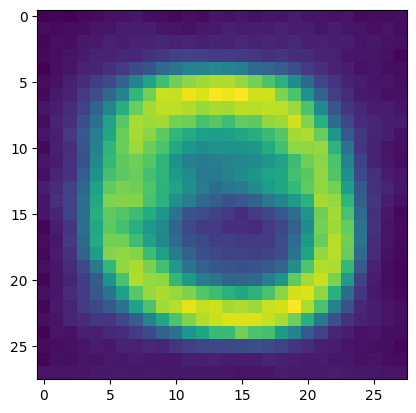

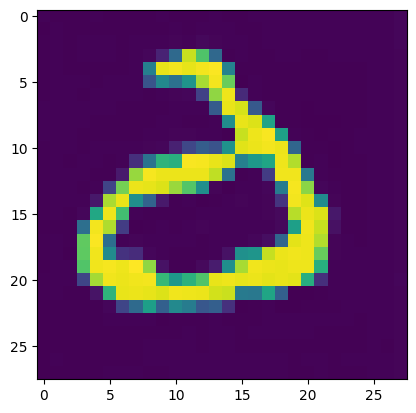

Regularization Term    tensor(-0.1315, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(1.0793, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3767, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


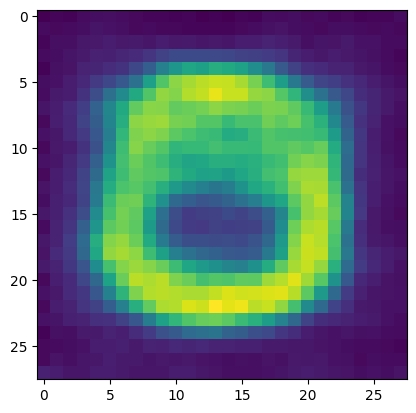

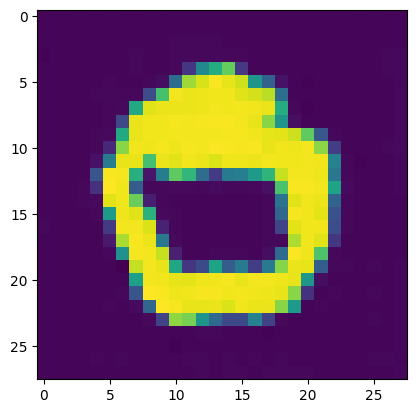

Regularization Term    tensor(-0.1329, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(1.0066, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3469, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


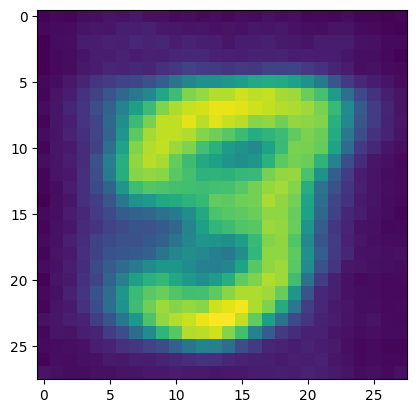

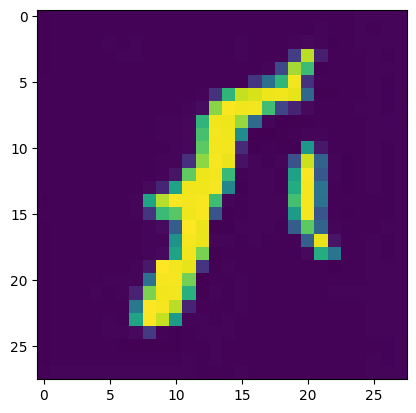

Regularization Term    tensor(-0.1375, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.9638, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3322, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


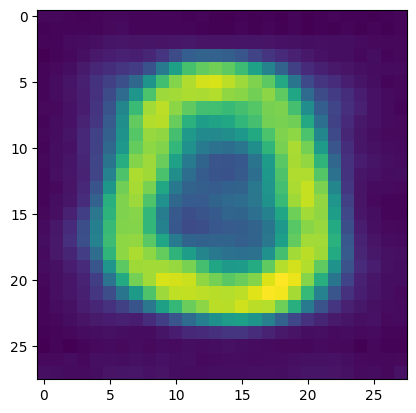

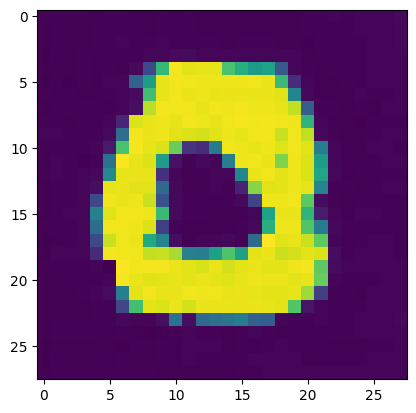

Regularization Term    tensor(-0.1398, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(1.0176, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3562, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


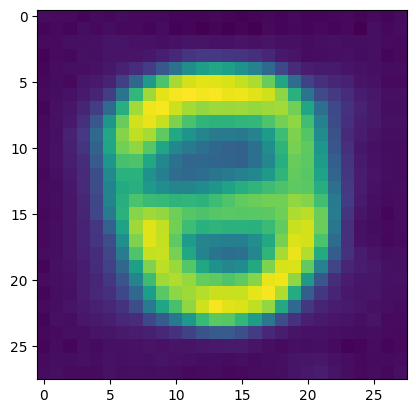

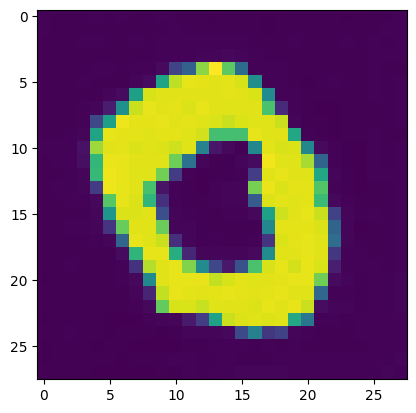

Regularization Term    tensor(-0.1374, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.8943, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3078, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


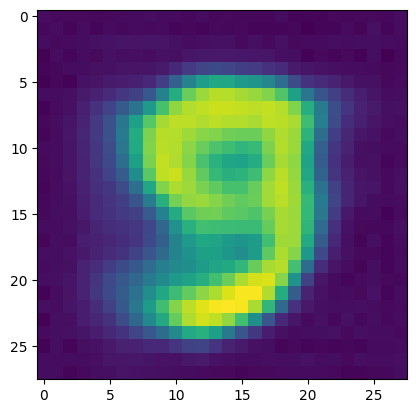

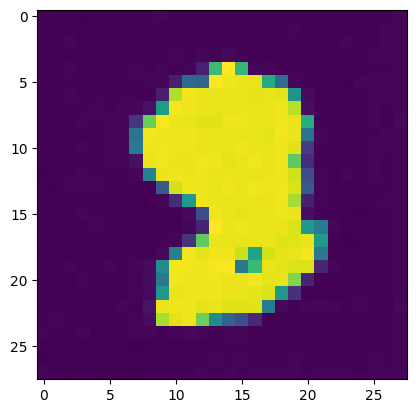

Regularization Term    tensor(-0.1381, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.9315, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3238, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


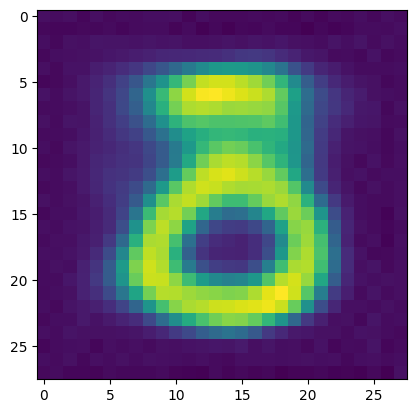

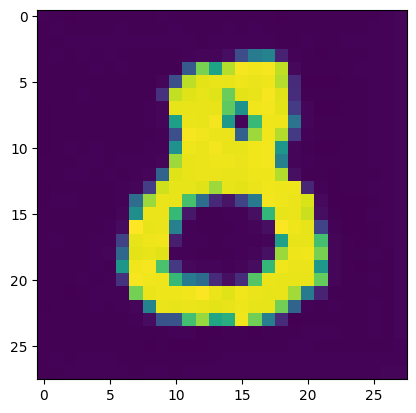

Regularization Term    tensor(-0.1259, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.9219, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3210, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


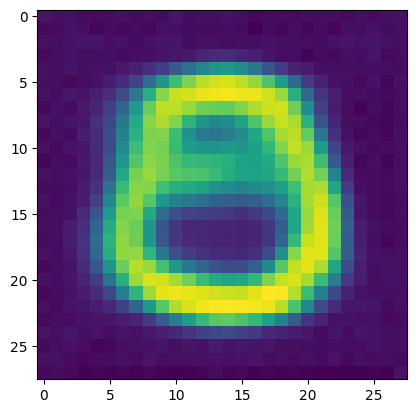

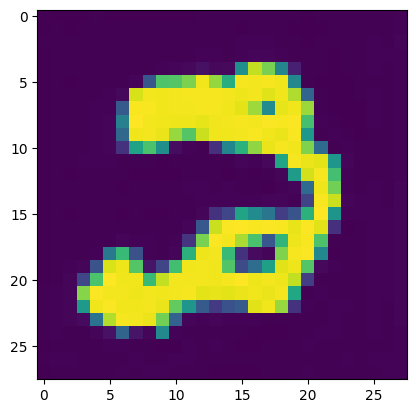

Regularization Term    tensor(-0.1223, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(1.0329, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3673, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


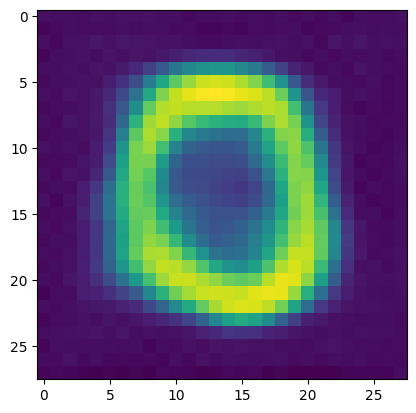

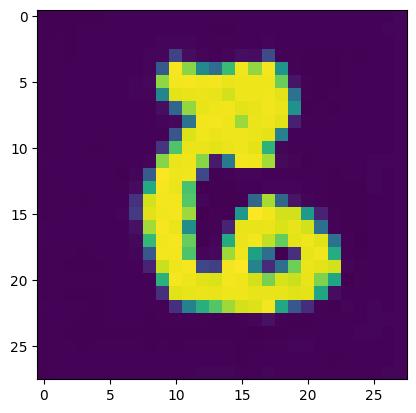

Regularization Term    tensor(-0.1110, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.9263, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3261, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3334, device='cuda:0', grad_fn=<AddBackward0>)


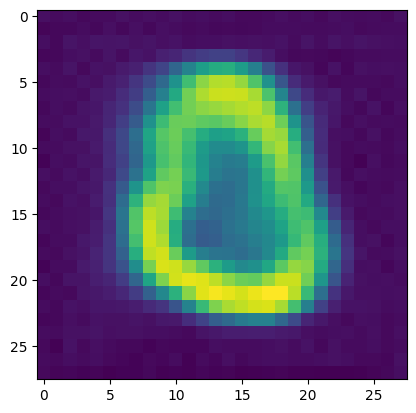

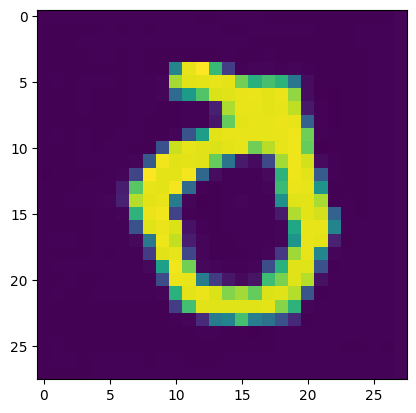

Regularization Term    tensor(-0.1091, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 0   Loss: tensor(0.8590, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2993, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


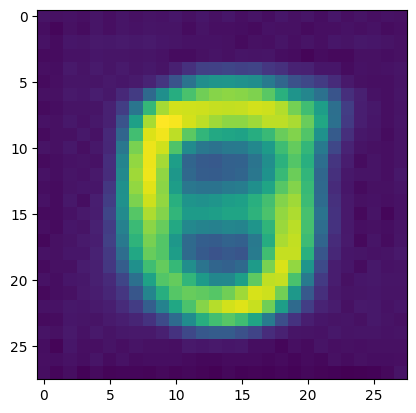

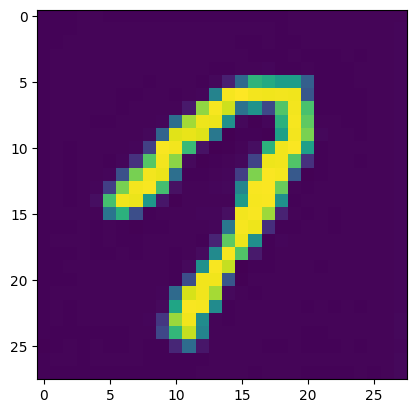

Regularization Term    tensor(-0.1082, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8004, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2740, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


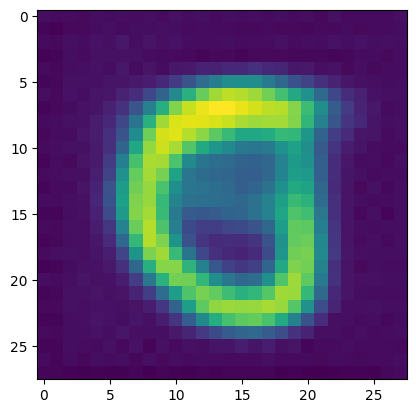

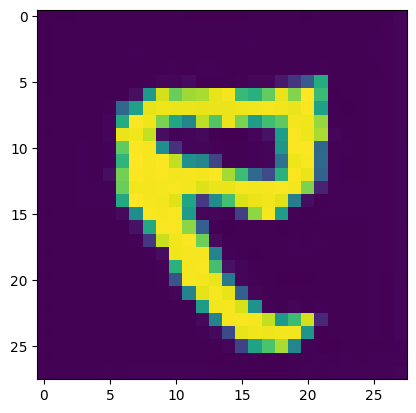

Regularization Term    tensor(-0.1045, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.7921, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2701, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


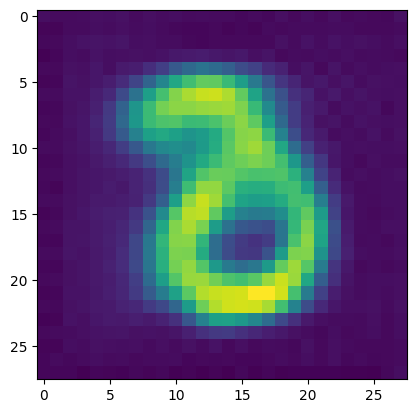

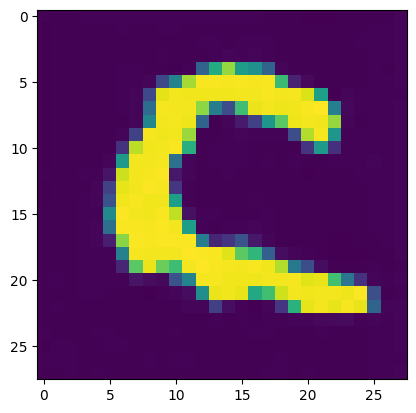

Regularization Term    tensor(-0.0977, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8095, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2779, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


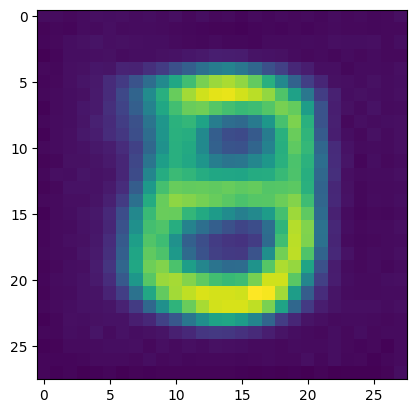

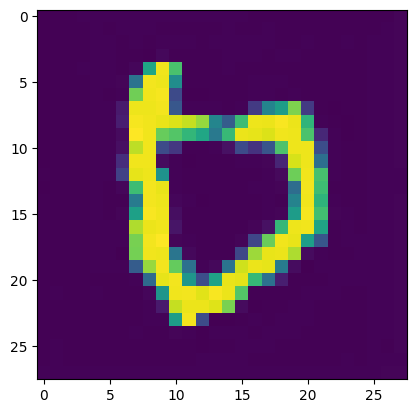

Regularization Term    tensor(-0.0875, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8015, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2753, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


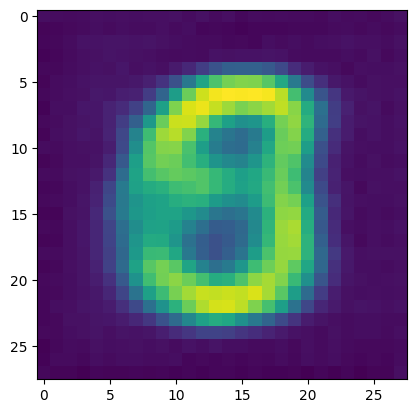

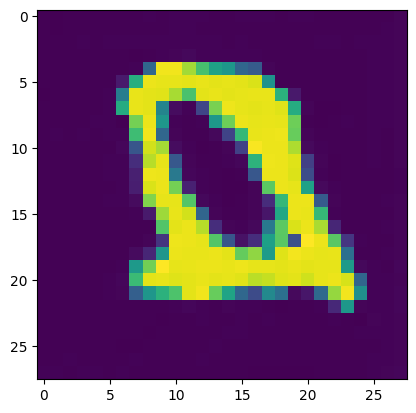

Regularization Term    tensor(-0.0824, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8650, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3008, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


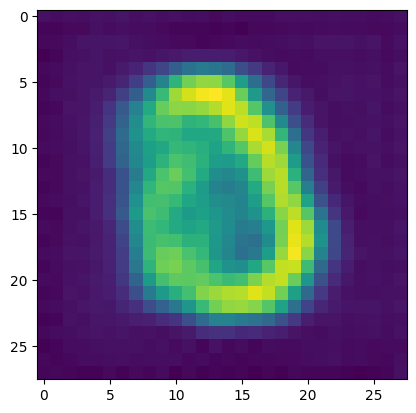

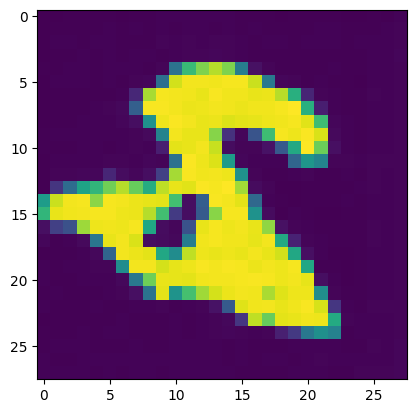

Regularization Term    tensor(-0.0785, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.7760, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2640, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


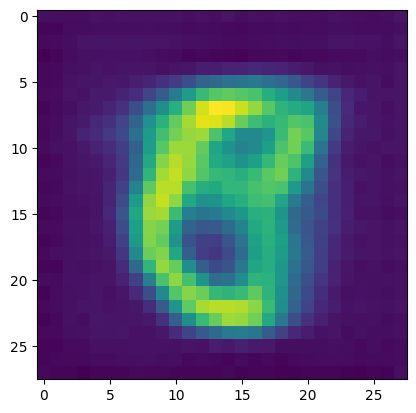

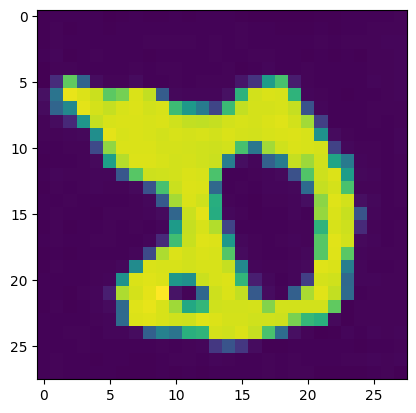

Regularization Term    tensor(-0.0789, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8663, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3006, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


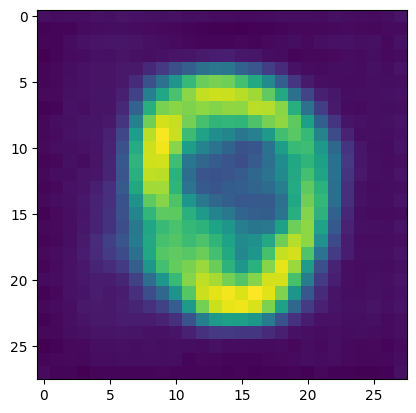

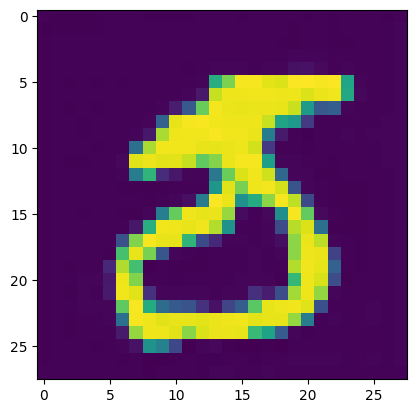

Regularization Term    tensor(-0.0706, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8336, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2871, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


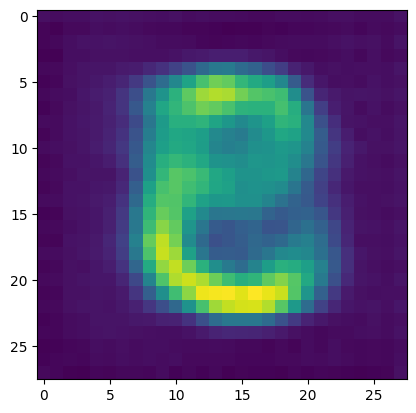

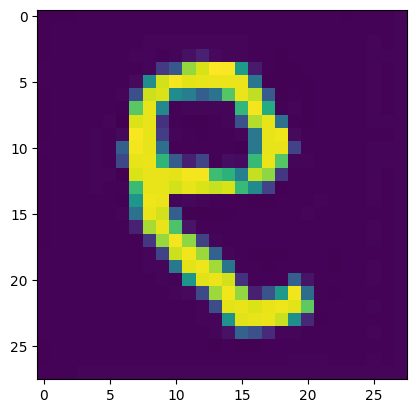

Regularization Term    tensor(-0.0646, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8462, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2925, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3954, device='cuda:0', grad_fn=<AddBackward0>)


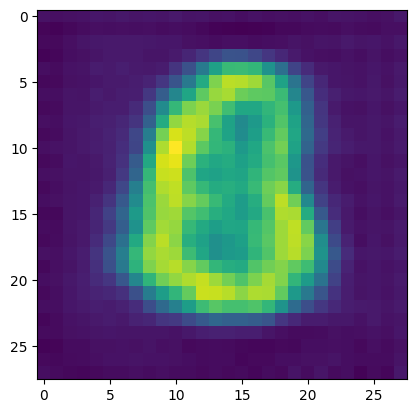

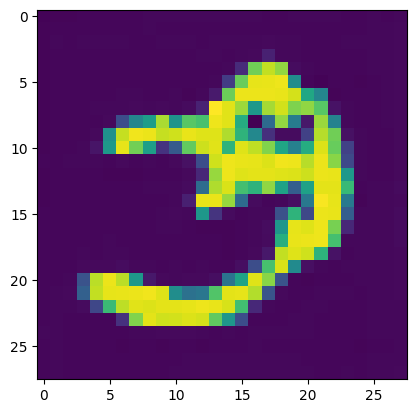

Regularization Term    tensor(-0.0639, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 1   Loss: tensor(0.8394, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2896, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


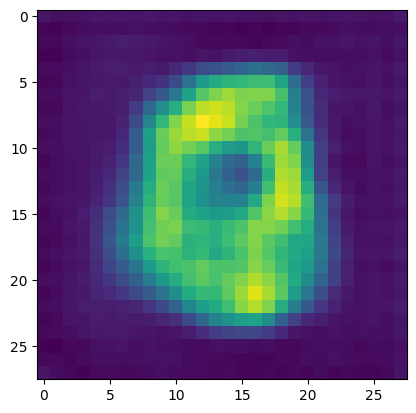

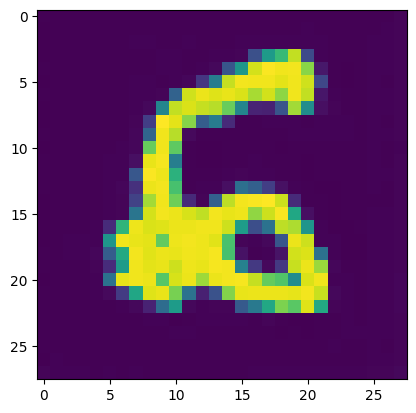

Regularization Term    tensor(-0.0573, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.7850, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2682, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


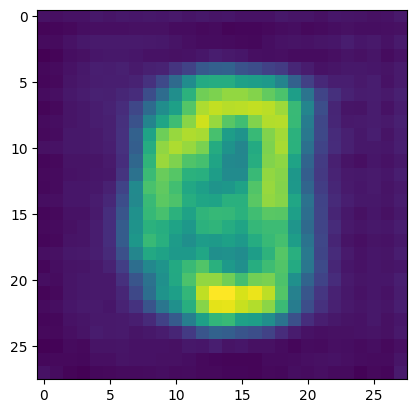

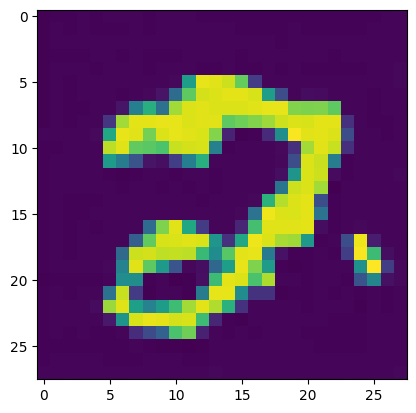

Regularization Term    tensor(-0.0534, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.8701, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3009, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


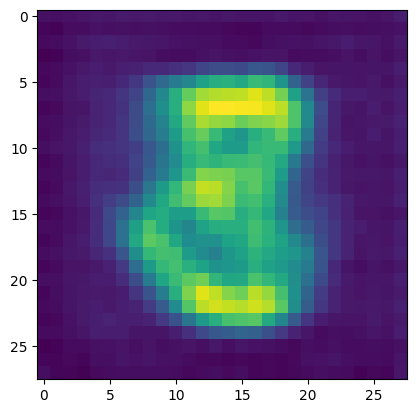

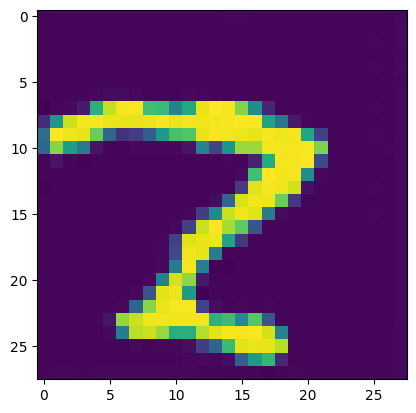

Regularization Term    tensor(-0.0507, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.8489, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2921, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


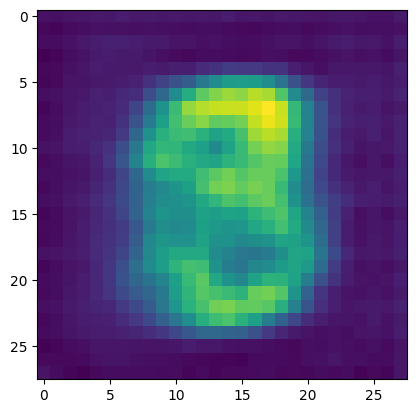

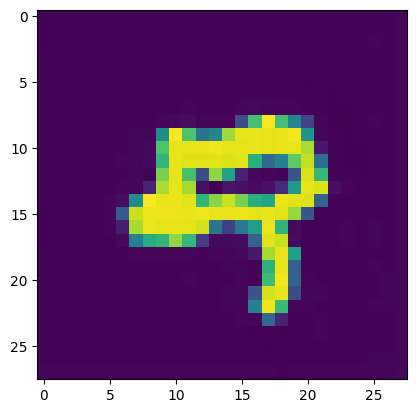

Regularization Term    tensor(-0.0487, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.7973, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2719, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


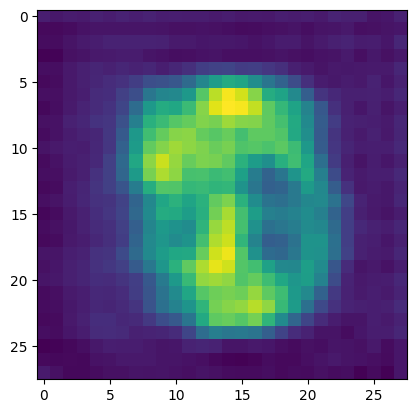

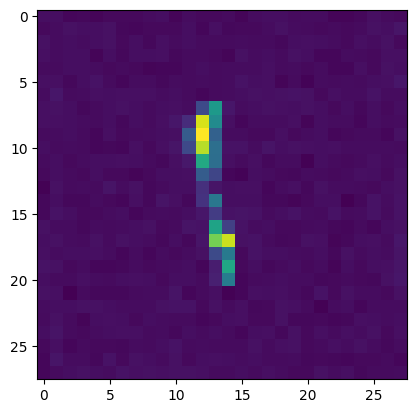

Regularization Term    tensor(-0.0448, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.8193, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2806, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


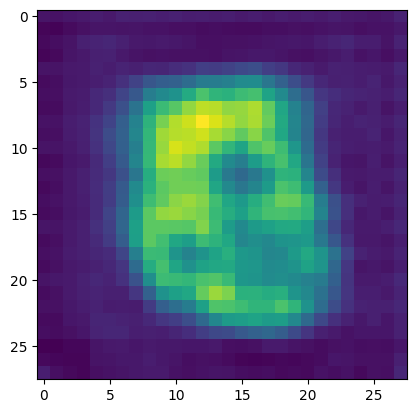

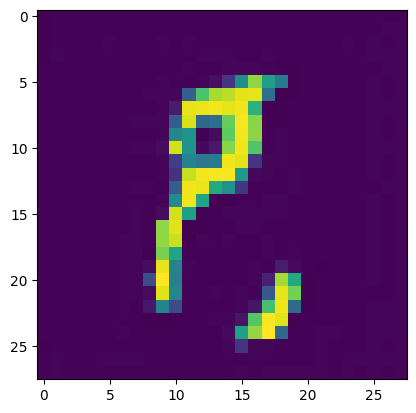

Regularization Term    tensor(-0.0408, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.7110, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2355, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


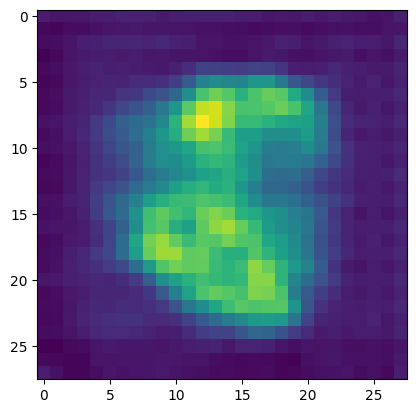

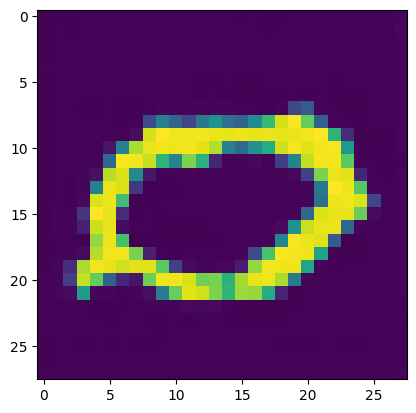

Regularization Term    tensor(-0.0403, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.7574, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2545, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


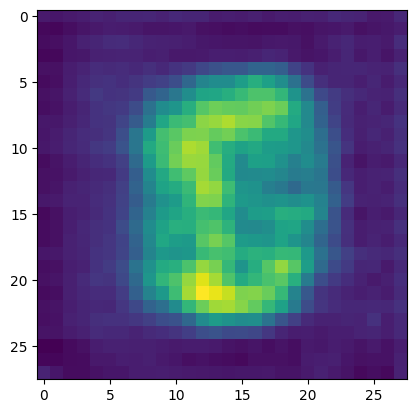

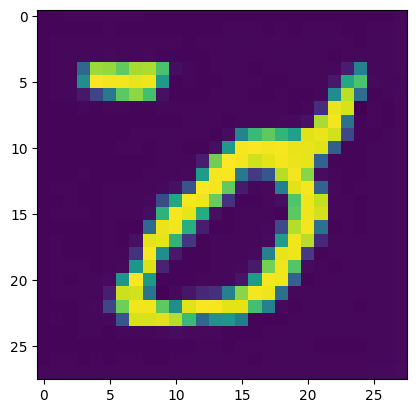

Regularization Term    tensor(-0.0373, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.8114, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2767, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


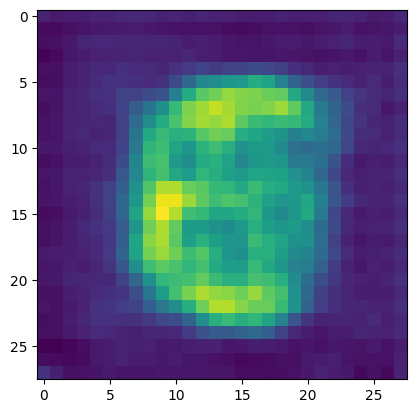

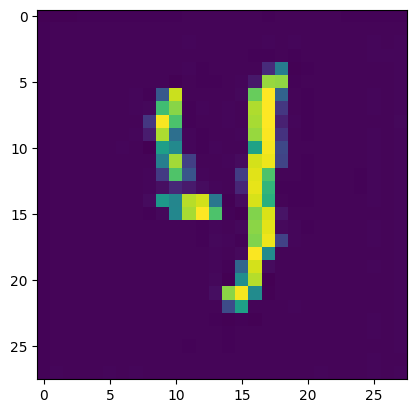

Regularization Term    tensor(-0.0368, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2561, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(2.3284, device='cuda:0', grad_fn=<AddBackward0>)


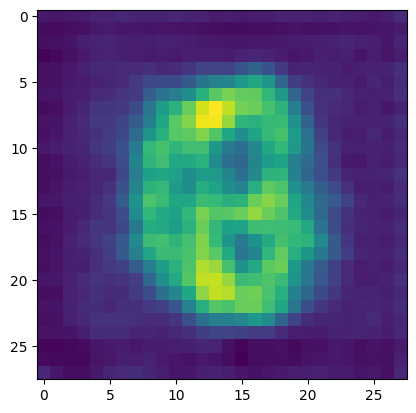

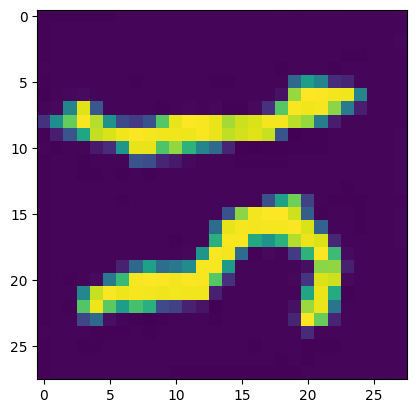

Regularization Term    tensor(-0.0371, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 2   Loss: tensor(0.7246, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2409, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


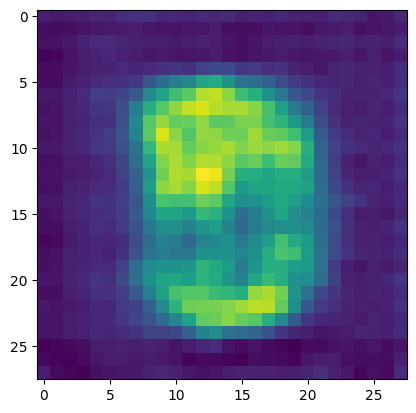

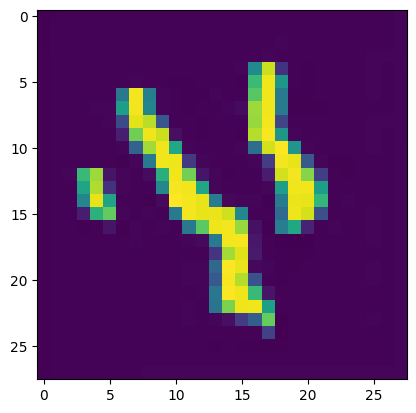

Regularization Term    tensor(-0.0351, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7258, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2446, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


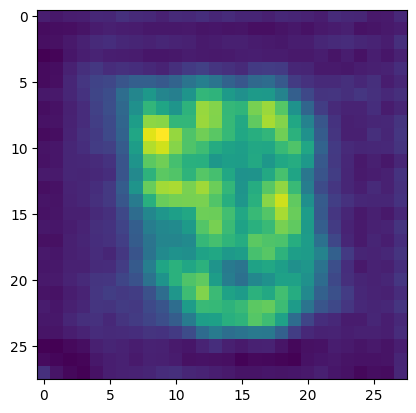

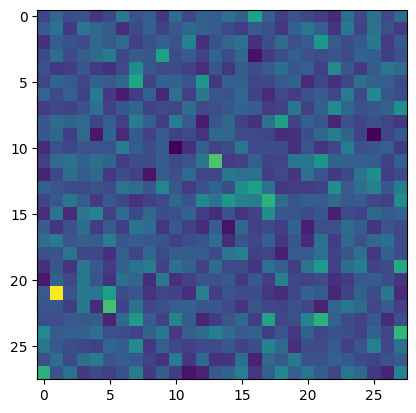

Regularization Term    tensor(-0.0330, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7550, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2548, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


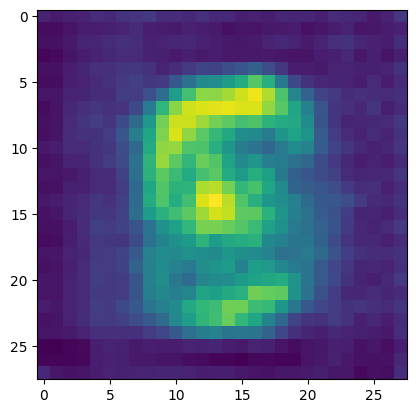

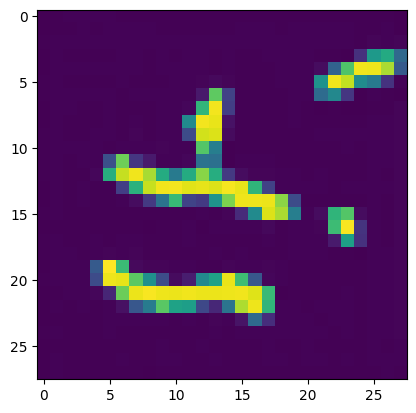

Regularization Term    tensor(-0.0327, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7817, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2656, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


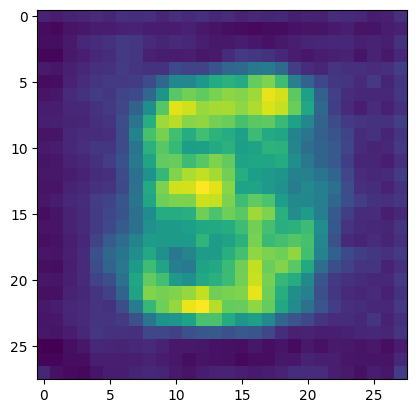

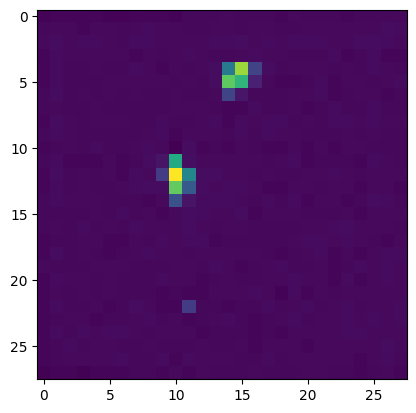

Regularization Term    tensor(-0.0320, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.6928, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2303, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


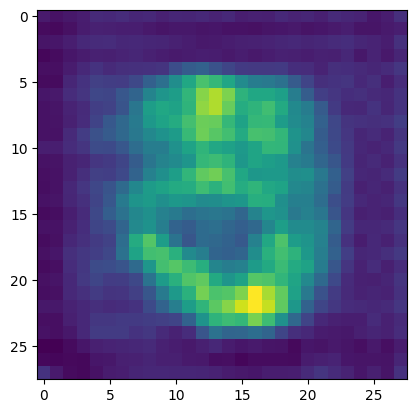

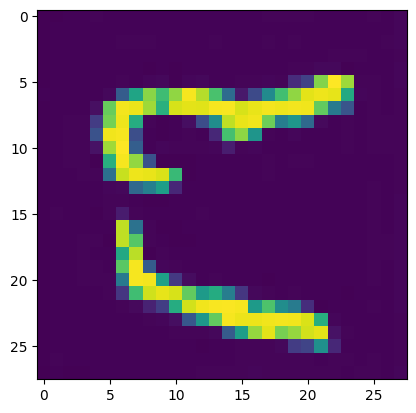

Regularization Term    tensor(-0.0318, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7189, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2405, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


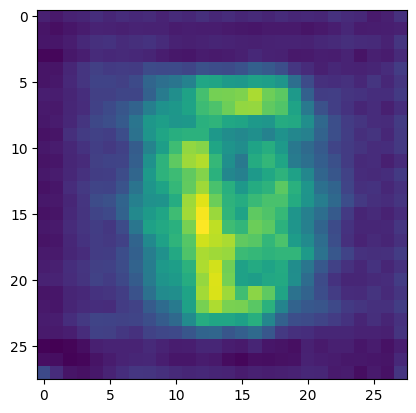

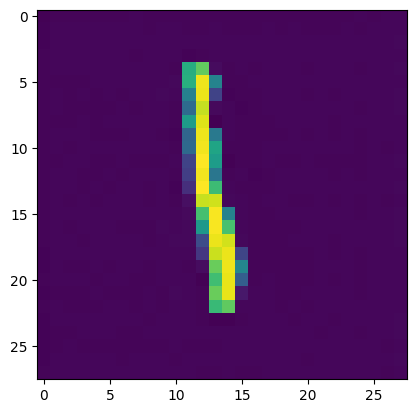

Regularization Term    tensor(-0.0300, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7452, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2508, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


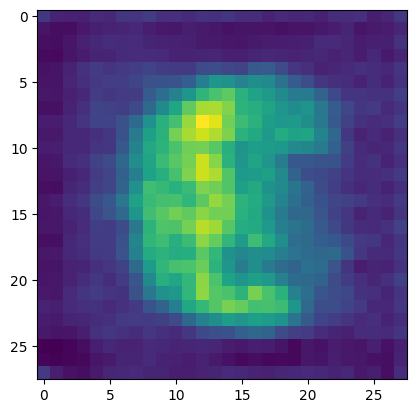

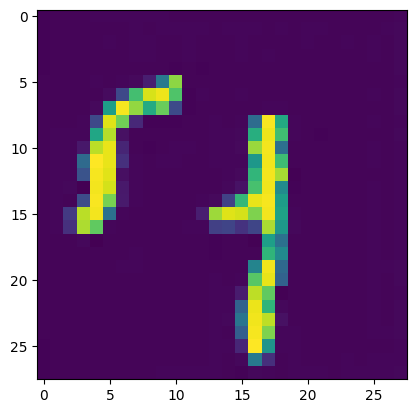

Regularization Term    tensor(-0.0302, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.6786, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2248, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


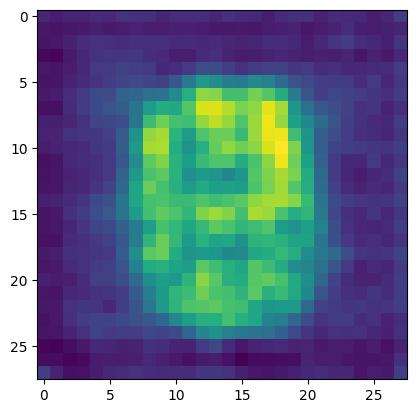

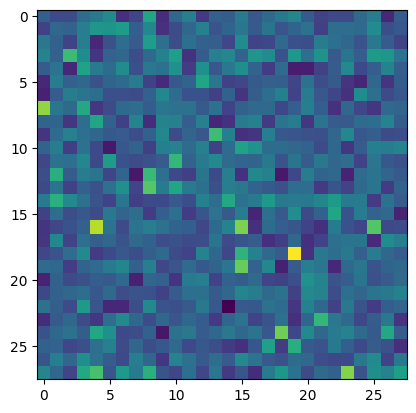

Regularization Term    tensor(-0.0304, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2393, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


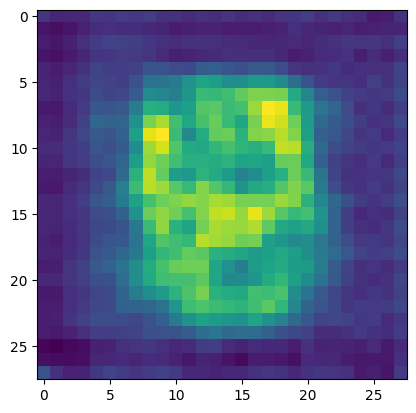

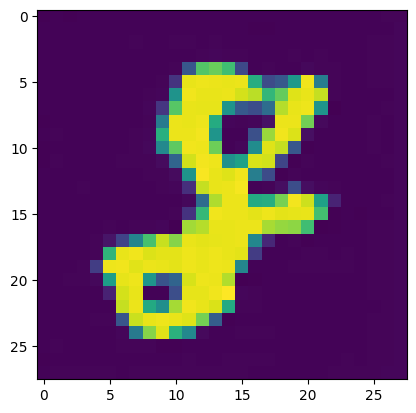

Regularization Term    tensor(-0.0298, device='cuda:0', grad_fn=<NegBackward0>)
Epoch: 3   Loss: tensor(0.7678, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2606, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.3050, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [67]:
torch.cuda.empty_cache()
epochs = 5

student_optimizer = Adam(student_model.parameters(), lr=1e-4, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=2, factor=0.05)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=2, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_teacher = torch.randint(0, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)

      input= torch.rand([64,1,28,28]).to(device)

      student_data = sample( student_model,  input , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0] , image_size, timestep=teacher_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      #show the results
      random_index = random.randint(0, 63)
      image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
      image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
      plt.imshow(image_data1)
      plt.show()
      plt.imshow(image_data3)
      plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      #regularization term useful to avoid mode collapse
      diversity_loss = -torch.mean(torch.abs(student_data[-1]  - student_data[-1].mean(dim=0)))
      print("Regularization Term    " + str(diversity_loss))

      loss = l*distill_loss + loss_fake #+  0.5 * diversity_loss
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

In [ ]:
discriminator_path = '/content/drive/MyDrive/discriminator_model_last_version.pth'
student_path = '/content/drive/MyDrive/student_model_last_version.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), discriminator_path)
#torch.save(student_model.state_dict(), student_path)

In [ ]:
path = '/content/drive/MyDrive/diffusion_model_last_version.pth'

# Salva il modello
#torch.save(diffusion_model.state_dict(), path)

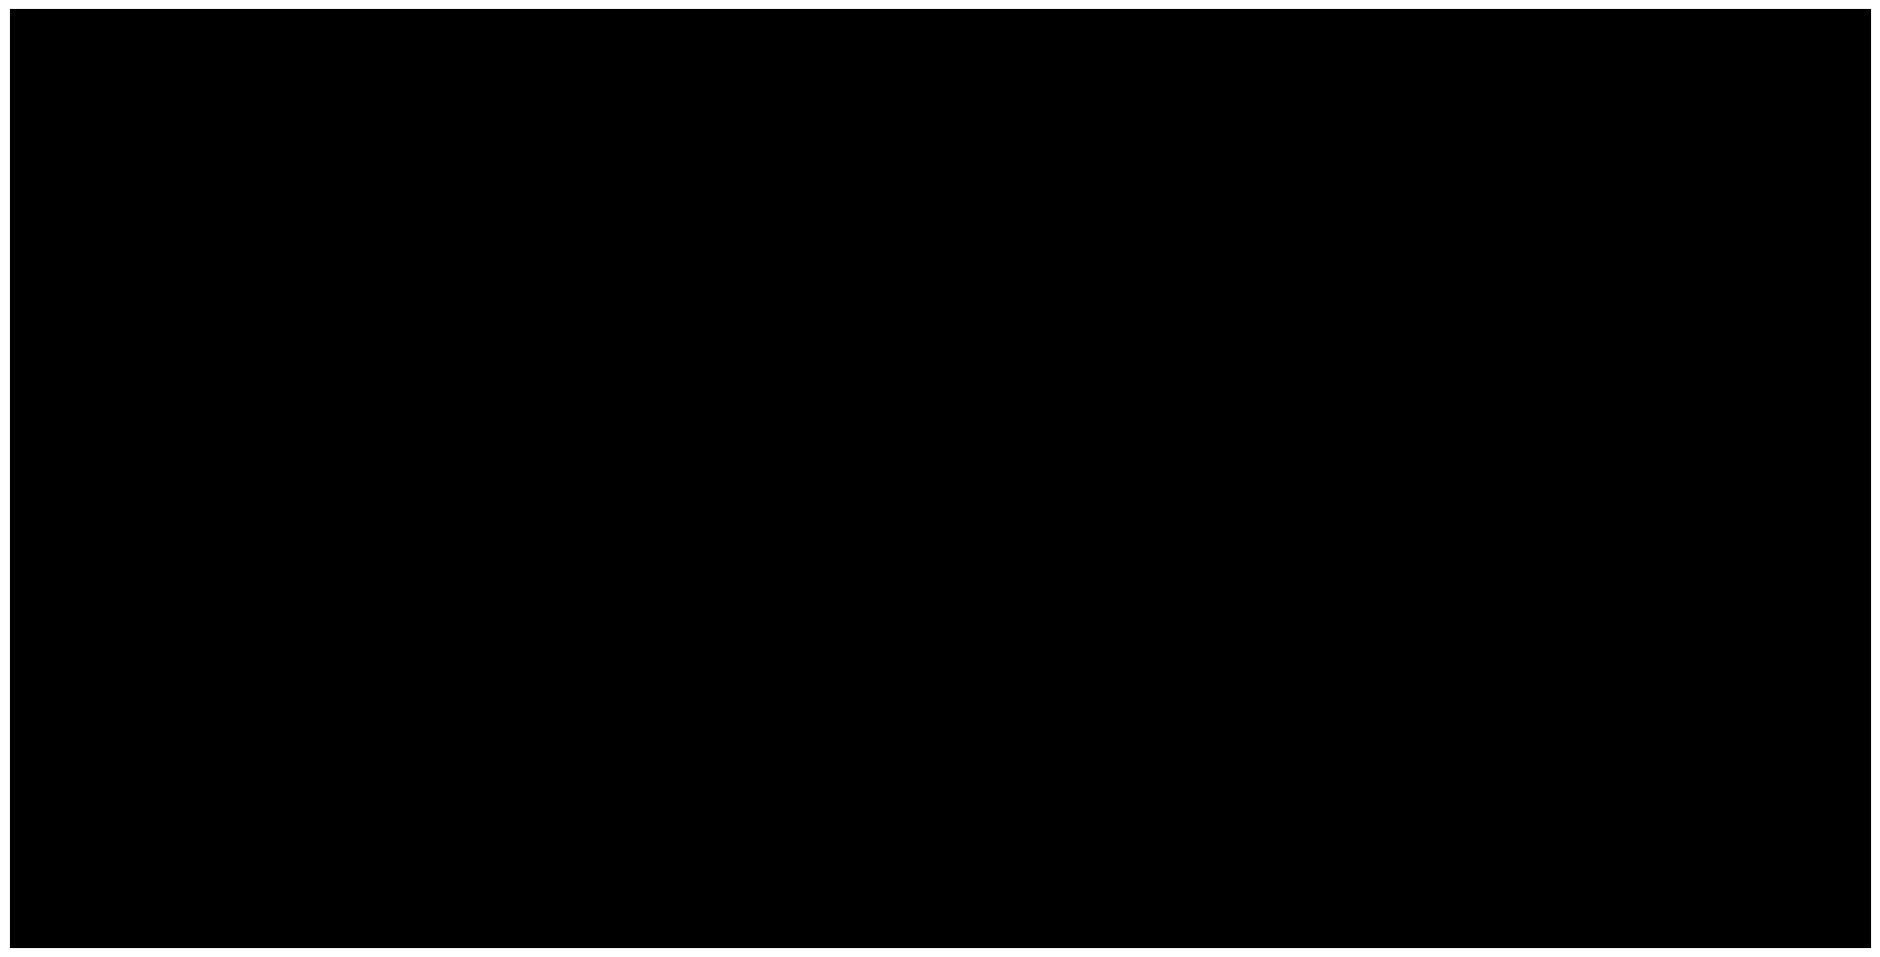

In [68]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device) #q_sample(x_start=t_student[0].to(device), t=t.to(device), noise=noise.to(device))
  student_data = sample(student_model, pure_noise, image_size=image_size, timestep=10,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(student_data[-1].cpu().detach())

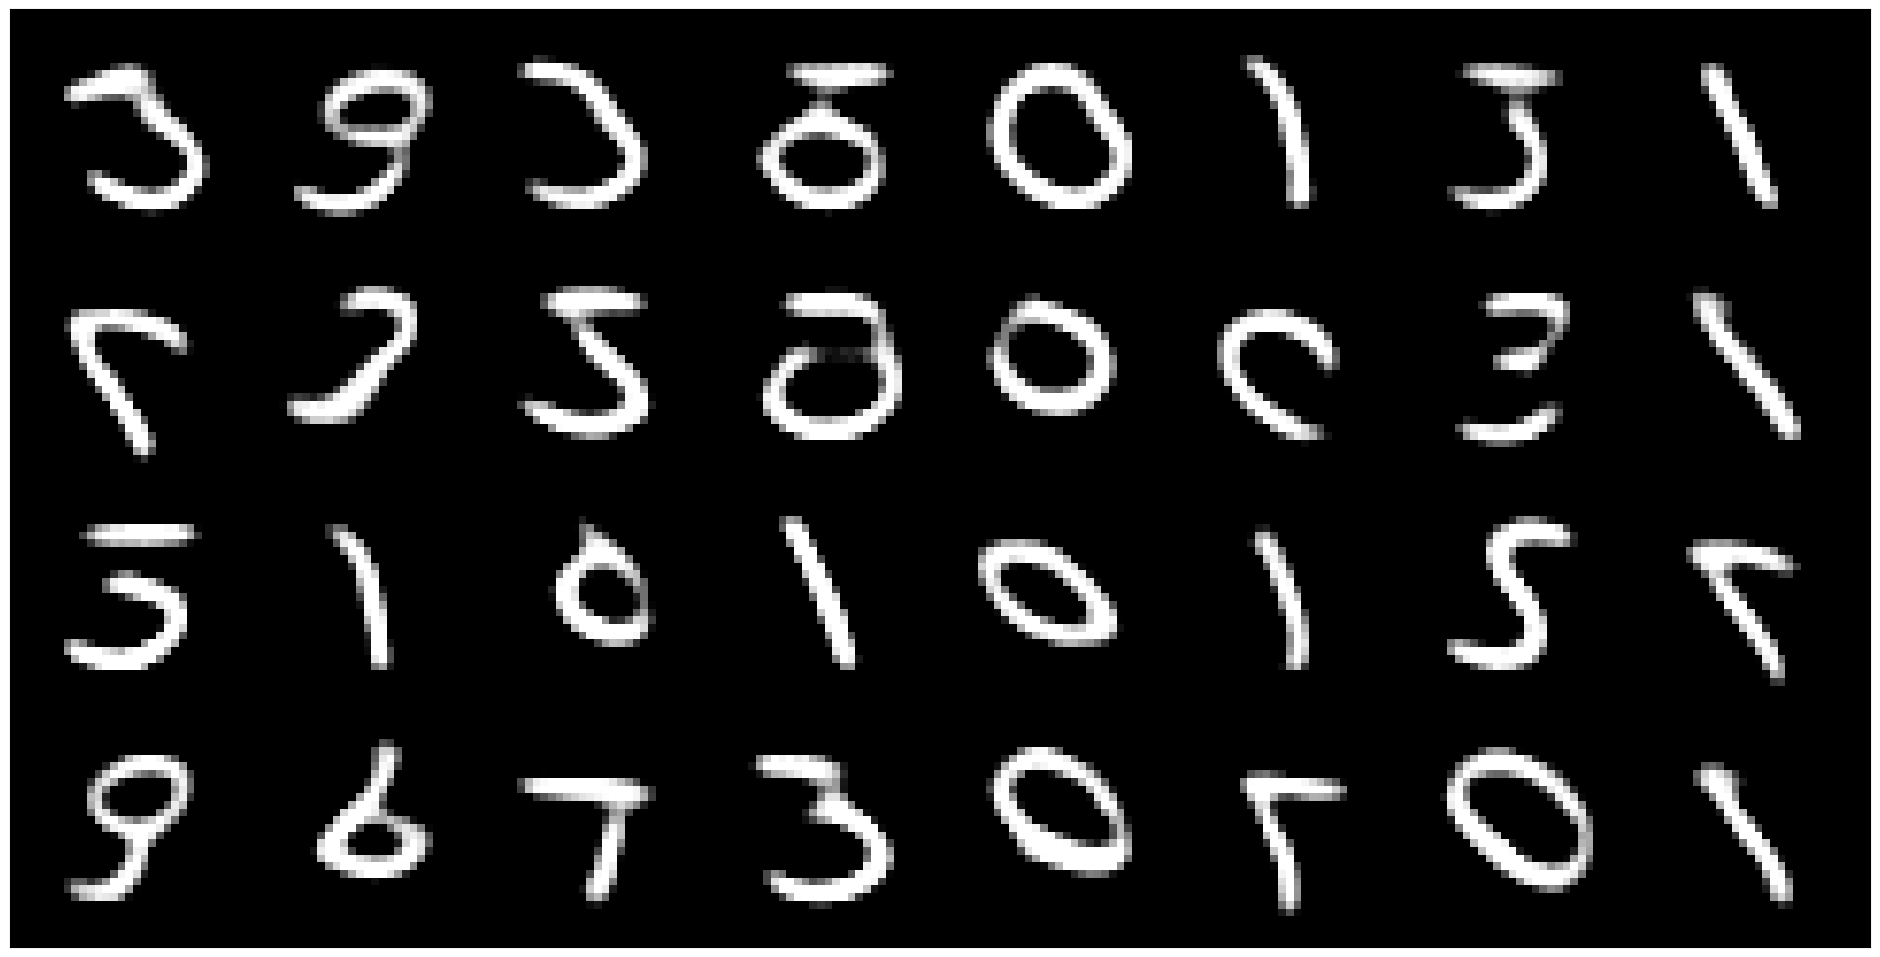

In [ ]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device) #q_sample(x_start=t_student[0].to(device), t=t.to(device), noise=noise.to(device))
  student_data = sample(student_model, pure_noise, image_size=image_size, timestep=10,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(student_data[-1].cpu().detach())

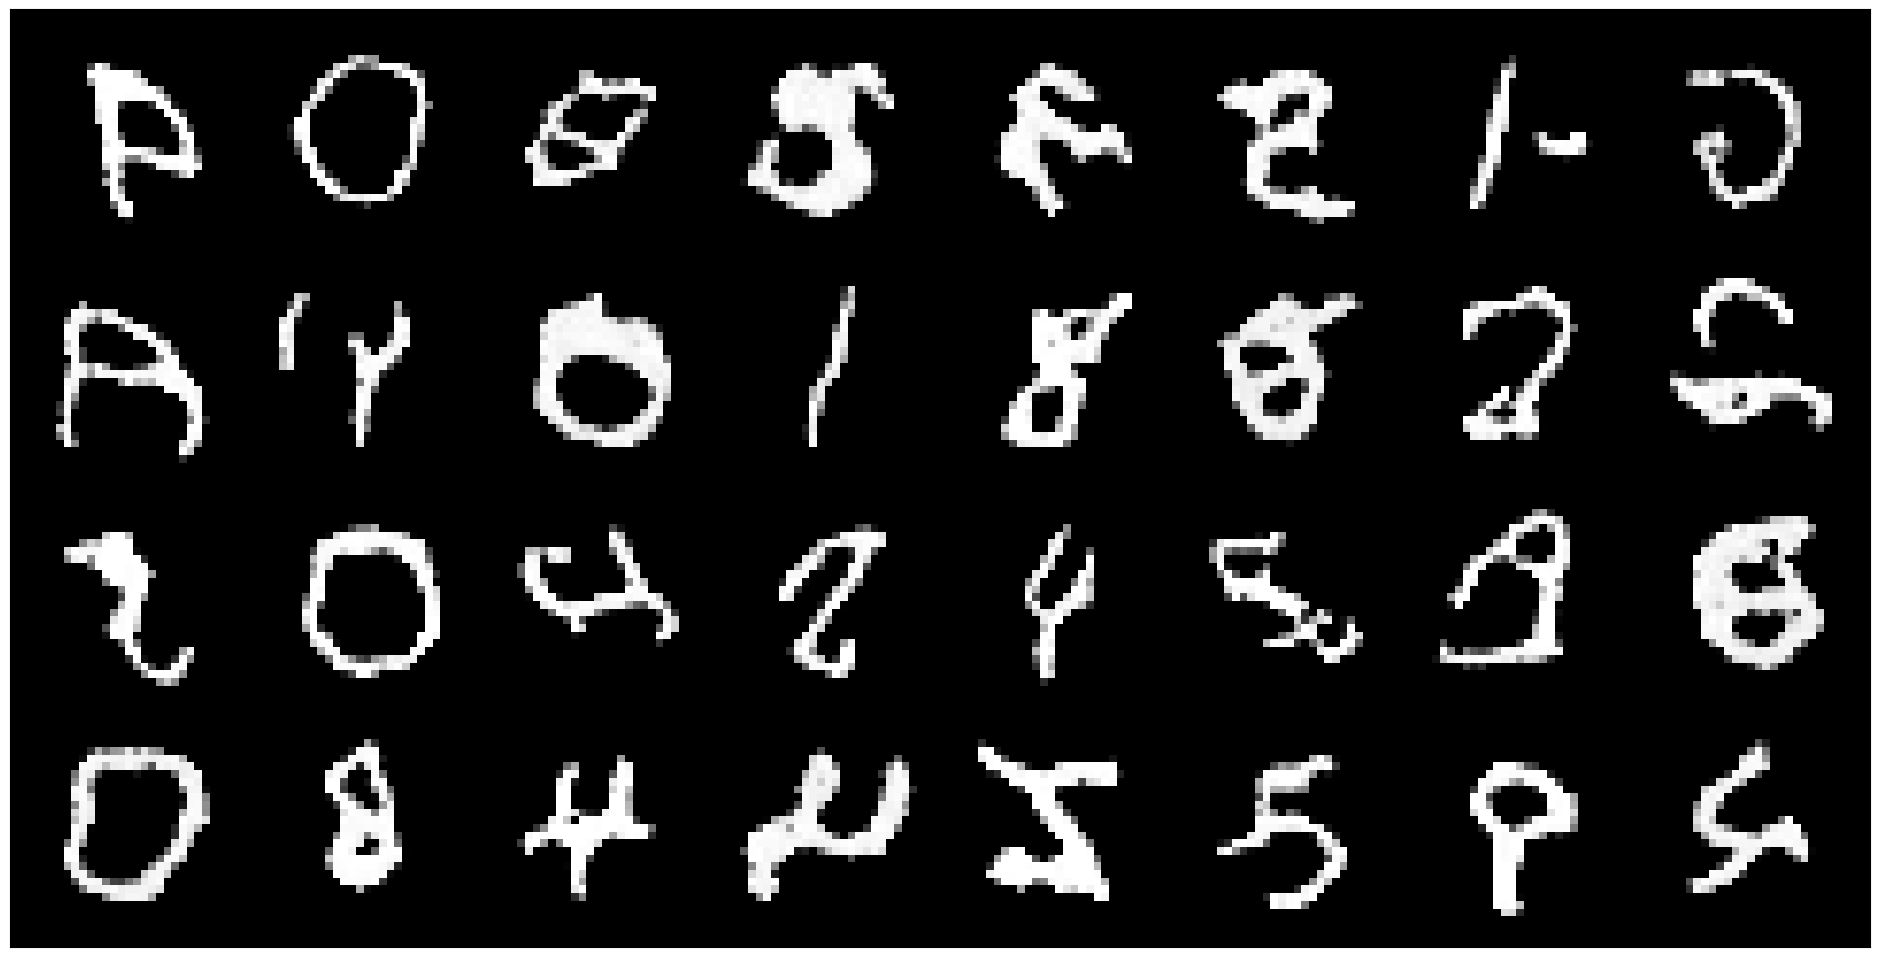

In [28]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device) #q_sample(x_start=t_student[0].to(device), t=t.to(device), noise=noise.to(device))
  student_data = sample(teacher_model, pure_noise, image_size=image_size, timestep=800,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(student_data[-1].cpu().detach())